### Human Emotion Rating Data EDA

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

from scipy.stats import skew


In [2]:
#Load Data
exp1_rating = pd.read_csv('../data/human-data/exp1_preprocessed.csv')  
exp2_rating = pd.read_csv('../data/human-data/exp2_preprocessed.csv')  
exp3_rating = pd.read_csv('../data/human-data/exp3_preprocessed.csv')  


In [3]:
exp3_rating.columns

Index(['Image Name', 'Emotion', 'Participant_Private', 'Emo_Rating',
       'Liking_Rating', 'Emo_Time', 'Image Category', 'Attention Score',
       'Device', 'Order', 'mean concreteness (high-level)',
       'mean dynamic (high-level)', 'mean temperature (high-level)',
       'li: average hue (global)', 'li: average saturation (global)',
       'li: number of hues (global)', 'li: area of most frequent hue (global)',
       'li: hue contrast (global)', 'li: Hue model -3 (global)',
       'li: Hue model -1 (global)', 'li: Hue model 0 (global)',
       'li: Hue model 1 (global)', 'li: Hue model 2 (global)',
       'li: Hue model 3 (global)',
       'li: arithmetic average brightness (global)',
       'li: logarithmic average brightness (global)',
       'li: brightness contrast (global)', 'li: blurring effect (global)',
       'li: edge distribution metric (global)',
       'li: horizontal coordinate of mass center for largest segment',
       'li: vertical coordinate of mass center for 

In [4]:
#picking out emotion rating and combine two dataframes
cols = ['Participant_Private','Image Name', 'Image Category', 'Emotion', 'Emo_Rating']
exp1_rating_filtered = exp1_rating[cols].copy()
exp2_rating_filtered = exp2_rating[cols].copy()
exp3_rating_filtered = exp3_rating[cols].copy()
human_df = pd.concat([exp1_rating_filtered, exp2_rating_filtered,exp3_rating_filtered], axis=0, ignore_index=True)

human_df.rename(columns={
    'Participant_Private': 'participant',
    'Image Name':         'image',
    'Image Category':     'image_category',
    'Emo_Rating':         'emo_rating'
}, inplace=True)



In [5]:
#combine image and image_category into a single column
human_df['image'] = (
    human_df['image'].astype(str)
    + '_'
    + human_df['image_category'].astype(str)
)


In [6]:
human_df

participant                                         image  \
0         8685107.0                        140abstract.jpg_leslie   
1         8685107.0                           141woman.jpg_leslie   
2         8685107.0                           145banjo.jpg_leslie   
3         8685107.0                          151guitar.jpg_leslie   
4         8685107.0                        170abstract.jpg_leslie   
...             ...                                           ...   
125072   13458459.0              la-jolla-arbor.jpg_impressionism   
125073   13458459.0  lake-in-the-mountains-1899.jpg_impressionism   
125074   13458459.0              not_detected_189365.jpg_abstract   
125075   13458459.0              not_detected_189367.jpg_abstract   
125076   13458459.0                        taboo-19631.jpg_Cubism   

       image_category   Emotion  emo_rating  
0              leslie     Anger        78.0  
1              leslie     Anger        25.0  
2              leslie     Anger         0.0  
3              leslie     Anger        60.0  
4              leslie     Anger        60.0  
...               ...       ...         ...  
125072  impressionism  Surprise        11.0  
125073  impressionism  Surprise        12.0  
125074       abstract  Surprise        11.0  
125075       abstract  Surprise        10.0  
125076         Cubism  Surprise        10.0  

[125077 rows x 5 columns]

### Exploratory Data Analysis 

#### Functions

In [105]:
#box plot
emotion_order = ['Joy', 'Sadness', 'Fear', 'Anger', 'Disgust', 'Surprise','Liking']

def box_plot(df, df_name, order=emotion_order):
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Emotion', y='emo_rating', data=df, order=order)
    plt.title(f'Box Plot of {df_name} Emotion Ratings by Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('Emo_Rating')
    plt.tight_layout()
    plt.show()




In [126]:
#Overall histogram
def overall_histogram(df, df_name):
    plt.figure(figsize=(10,6))
    sns.histplot(df['emo_rating'], bins=30, kde=True, alpha=0.6)
    
    plt.title(f'Distribution of {df_name} Emotion Ratings')
    plt.xlabel('Emo_Rating')
    plt.ylabel('Count')
    plt.show()


In [120]:
#Histogram per emotion
def emotion_histogram(df, df_name, order=emotion_order):
    g = sns.FacetGrid(
        df,
        col='Emotion',
        col_wrap=3,
        col_order=order,
        sharex=True,
        sharey=True,
        height=3.5
    )
    g.map(sns.histplot, 'emo_rating', bins=30, kde=True, alpha=0.6)
    g.set_axis_labels('Emo_Rating', 'Count')
    g.fig.suptitle(f'Distribution of {df_name} Emotion Ratings', y=1.02)
    plt.tight_layout()
    plt.show()

In [10]:
#quantify skewness of emotion ratings
def emotion_skewness(df, df_name):
    print(f"Skewness of {df_name} Emotion Ratings:")
    for emo in df['Emotion'].unique():
        ratings = df[df['Emotion'] == emo]['emo_rating'].dropna()
        skewness = skew(ratings)
        print(f"{emo}: skewness = {skewness:.3f}")

In [11]:
# Emotion correlation heatmap
def image_category_heatmap(df, df_name):
    pivot_cat_em = (
        df
        .groupby(['image_category','Emotion'])['emo_rating']
        .mean()
        .unstack()
    )

    plt.figure(figsize=(8,6))
    sns.heatmap(
        pivot_cat_em,
        annot=True, fmt=".1f",
        cbar_kws={'label':'Mean Rating'}
    )
    plt.title(f'Mean {df_name} Rating by Image Category x Emotion')
    plt.ylabel('Image Category')
    plt.xlabel('Emotion')
    plt.show()

In [12]:
# Correlation heatmap + dendrogram
def emotion_category(df, df_name):
    img_profiles = (
        df
        .groupby(['image','Emotion'])['emo_rating']
        .mean()
        .unstack()
    )

    corr = img_profiles.corr()

    # 4.3 Heatmap of emotion correlations
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, fmt=".2f", 
                cmap='vlag', center=0,
                cbar_kws={'label':'Pearson r'})
    plt.title(f'Correlation Among Emotions in {df_name}')
    plt.show()

    # 4.4 Dendrogram clustering of emotions
    linkage = sch.linkage(corr, method='average')
    plt.figure(figsize=(6,4))
    sch.dendrogram(linkage, labels=corr.columns, leaf_rotation=45)
    plt.title(f'Hierarchical Clustering of Emotions in {df_name}')
    plt.ylabel('Distance')
    plt.tight_layout()
plt.show()

In [13]:
def pca_biplot(df, df_name, group_key='image'):
    """
    df: DataFrame with columns ['image','Emotion','emo_rating']
    group_key: name of the column in df to group by (e.g. 'image' or 'image_category')
    """
    # 1) Build image × emotion matrix and drop any rows with missing values
    profiles = (
        df
        .groupby([group_key, 'Emotion'])['emo_rating']
        .mean()
        .unstack()
        .dropna(axis=0)
    )

    # 2) Standardize each emotion dimension
    scaler = StandardScaler()
    X = scaler.fit_transform(profiles.values)

    # 3) Fit PCA to 2 components
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)

    # 4) Build a plotting DataFrame
    vis_df = pd.DataFrame(
        coords,
        columns=['PC1','PC2'],
        index=profiles.index
    ).reset_index()

    # 5) Prepare loadings for arrows
    loadings = pca.components_.T
    # Scale arrows so they’re visible relative to the point cloud
    scale = np.max(np.abs(coords)) * 0.7

    # 6) Plot
    plt.figure(figsize=(8,6))
    # a) scatter of paintings
    sns.scatterplot(
        data=vis_df,
        x='PC1', y='PC2',
        alpha=0.6,
        s=50
    )
    # b) emotion vectors
    for i, emo in enumerate(profiles.columns):
        x_vec, y_vec = loadings[i] * scale
        plt.arrow(
            0, 0,
            x_vec, y_vec,
            color='red',
            width=0.005,
            head_width=0.1,
            length_includes_head=True
        )
        plt.text(
            x_vec * 1.1, y_vec * 1.1,
            emo,
            color='red',
            ha='center',
            va='center',
            fontsize=10
        )

    # 7) Labels and aesthetics
    var1, var2 = pca.explained_variance_ratio_ * 100
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.xlabel(f"PC1 ({var1:.1f}% var)")
    plt.ylabel(f"PC2 ({var2:.1f}% var)")
    plt.title(f" {df_name} PCA Biplot (Paintings x Emotion)")
    plt.tight_layout()
    plt.show()


In [14]:
def pca_analysis(
    df,
    df_name,
    group_key='image',
    n_components=None,
    scree=True,
    biplot=True,
    cumvar_threshold=0.90
):
    """
    Perform PCA on the image×emotion matrix built from `df`, then visualize.
    Adapts n_components to <= min(n_samples, n_features).
    """
    # 1. Build the profiles matrix
    profiles = (
        df
        .groupby([group_key, 'Emotion'])['emo_rating']
        .mean()
        .unstack()
        .dropna(axis=0)
    )
    X = StandardScaler().fit_transform(profiles.values)
    n_feats = X.shape[1]
    n_samples = X.shape[0]
    
    # Determine max allowable components
    max_comp = min(n_components or n_feats, n_feats, n_samples)
    
    if n_components and n_components > max_comp:
        print(f"Warning: requested n_components={n_components} reduced to {max_comp} "
              f"(min(n_samples={n_samples}, n_features={n_feats})).")
    
    n_comp = max_comp

    # 2. Fit PCA
    pca = PCA(n_components=n_comp)
    coords = pca.fit_transform(X)

    # Build coords_df
    cols = [f"PC{i+1}" for i in range(n_comp)]
    coords_df = pd.DataFrame(coords, columns=cols, index=profiles.index).reset_index()

    # 3. Scree + cumulative plots
    evr = pca.explained_variance_ratio_
    if scree:
        plt.figure(figsize=(5,3))
        plt.plot(range(1, n_comp+1), evr, 'o-')
        plt.title(f"{df_name}: Scree Plot")
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.xticks(range(1, n_comp+1))
        plt.tight_layout()
        plt.show()

    cumvar = np.cumsum(evr)
    plt.figure(figsize=(5,3))
    plt.plot(range(1, n_comp+1), cumvar, 'o-')
    plt.axhline(cumvar_threshold, linestyle='--', color='gray',
                label=f"{int(cumvar_threshold*100)}% var")
    plt.title(f"{df_name}: Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Ratio")
    plt.xticks(range(1, n_comp+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. 2D Biplot on PC1 vs PC2
    if biplot and n_comp >= 2:
        loadings = pca.components_.T
        scale = np.max(np.abs(coords[:, :2])) * 0.7

        plt.figure(figsize=(6,5))
        sns.scatterplot(data=coords_df, x='PC1', y='PC2', alpha=0.6, s=40)
        for i, emo in enumerate(profiles.columns):
            x_vec, y_vec = loadings[i, :2] * scale
            plt.arrow(0, 0, x_vec, y_vec, color='red', width=0.003,
                      head_width=0.08, length_includes_head=True)
            plt.text(x_vec*1.1, y_vec*1.1, emo, color='red',
                     ha='center', va='center')

        var1, var2 = evr[0]*100, evr[1]*100
        plt.axhline(0, color='gray', lw=0.5)
        plt.axvline(0, color='gray', lw=0.5)
        plt.xlabel(f"PC1 ({var1:.1f}% var)")
        plt.ylabel(f"PC2 ({var2:.1f}% var)")
        plt.title(f"{df_name}: PCA Biplot ({group_key} x Emotion)")
        plt.tight_layout()
        plt.show()

    return pca, coords_df


In [15]:
#pearson correlation plot
def pearson_correlation_plot(df):
    # Overall relationship with trend line
    x = df['emo_rating_human']
    y = df['emo_rating_llm']
    r_all, _ = pearsonr(x, y)

    plt.figure()
    plt.scatter(x, y, alpha=0.5)

    # identity line
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    plt.plot(lims, lims, color='gray', linestyle='--', label='y = x')

    # trend line
    m, b = np.polyfit(x, y, 1)
    plt.plot(lims, [m*lim + b for lim in lims],
            color='red', linestyle='-', label=f'y = {m:.2f}x + {b:.2f}')

    plt.xlabel('Human rating')
    plt.ylabel('LLM rating')
    plt.title(f'Overall Pearson r = {r_all:.3f}')
    plt.legend()
    plt.show()


    # Per‐emotion plots with trend lines
    for emo in df['Emotion'].unique():
        sub = df[df['Emotion'] == emo]
        x = sub['emo_rating_human']
        y = sub['emo_rating_llm']
        r, _ = pearsonr(x, y)
        print(f"{emo}: r = {r:.3f}")

        plt.figure()
        plt.scatter(x, y, alpha=0.5)

        lims = [min(x.min(), y.min()), max(x.max(), y.max())]
        plt.plot(lims, lims, color='gray', linestyle='--')

        m, b = np.polyfit(x, y, 1)
        plt.plot(lims, [m*lim + b for lim in lims],
                color='red', linestyle='-',
                label=f'y = {m:.2f}x + {b:.2f}')

        plt.xlabel('Human rating')
        plt.ylabel('LLM rating')
        plt.title(f'{emo}: Pearson r = {r:.3f}')
        plt.legend()
        plt.show()


### Analysis

In [16]:
#check number of unique participants 
human_df['participant'].nunique(), human_df['image'].nunique(), human_df['image_category'].nunique(), human_df['Emotion'].nunique()


(222, 972, 5, 6)

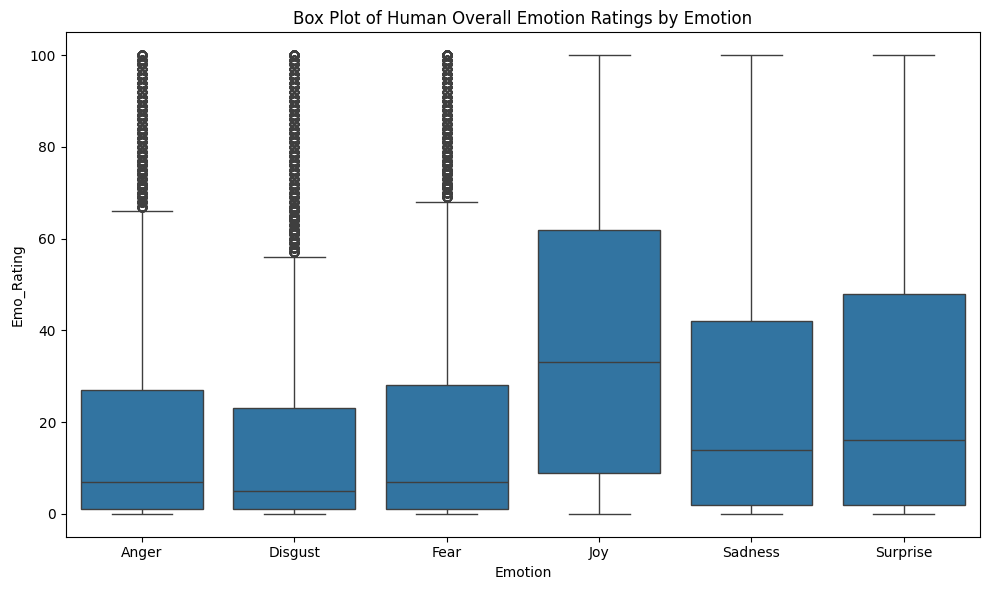

In [17]:
box_plot(human_df,'Human Overall')

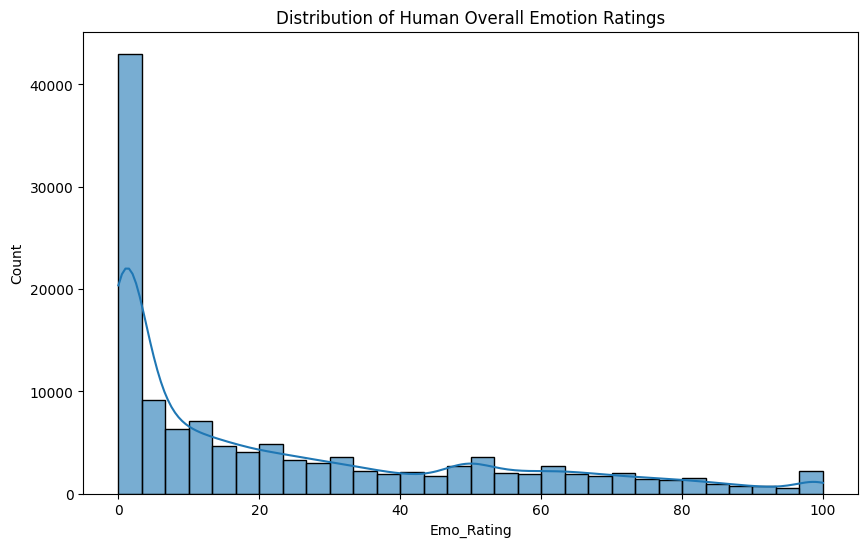

In [18]:
overall_histogram(human_df, 'Human Overall')

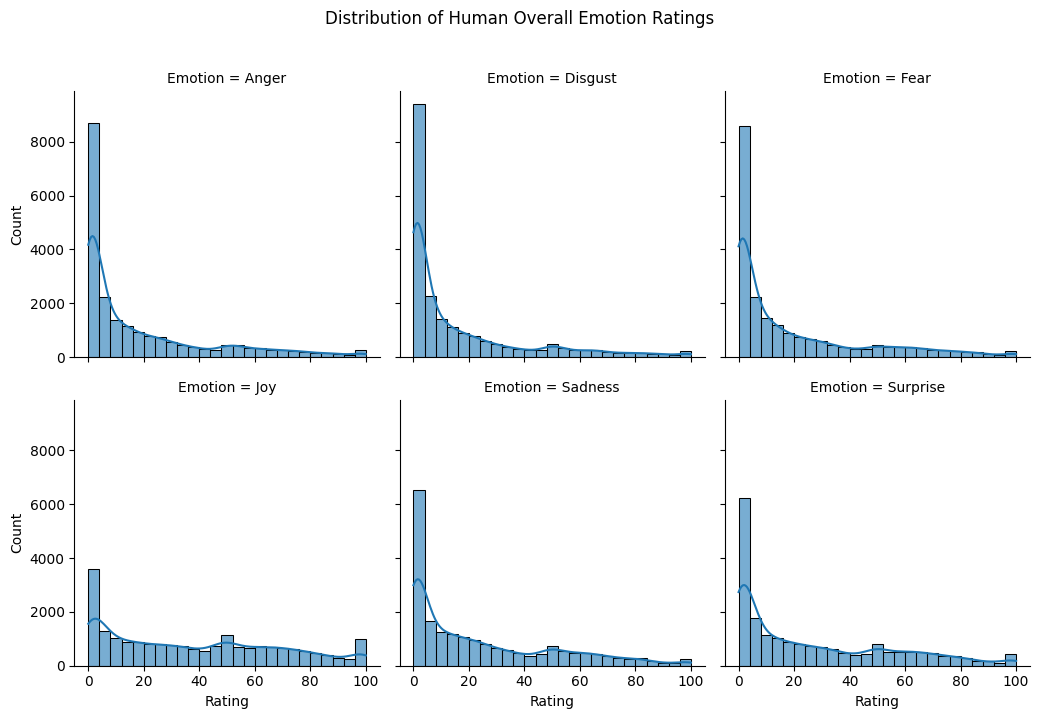

In [19]:
emotion_histogram(human_df, 'Human Overall')

In [20]:
emotion_skewness(human_df, 'Human Overall')

Skewness of Human Overall Emotion Ratings:
Anger: skewness = 1.501
Disgust: skewness = 1.726
Fear: skewness = 1.463
Joy: skewness = 0.406
Sadness: skewness = 1.030
Surprise: skewness = 0.901


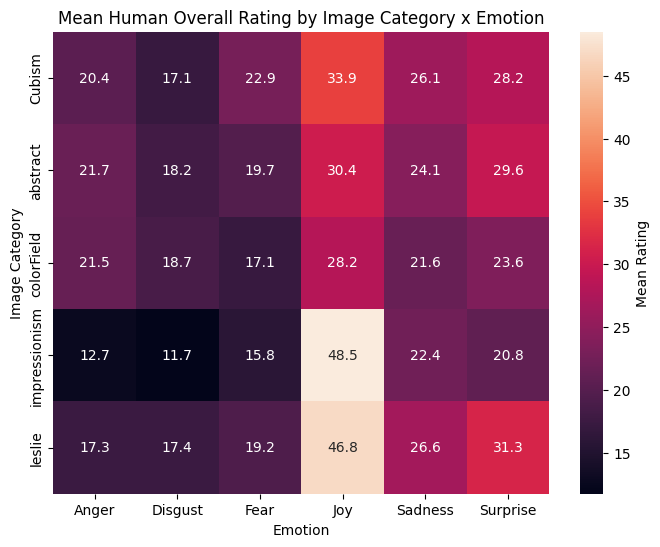

In [21]:
image_category_heatmap(human_df, 'Human Overall')

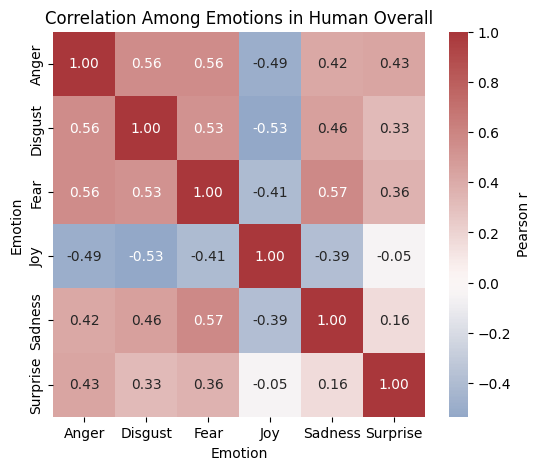

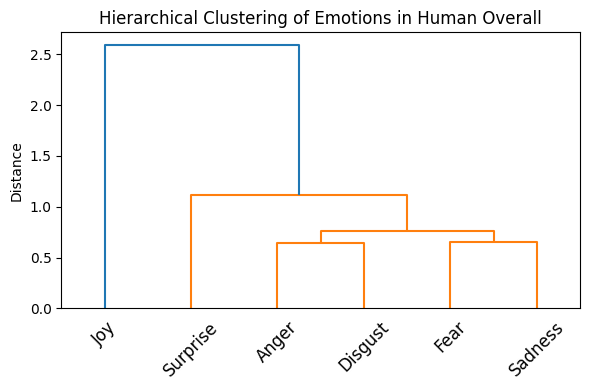

In [22]:
emotion_category(human_df, 'Human Overall')

### Import LLM data

In [23]:
# DF to have one row per image, with all emotion ratings
data_dir = Path("../output/analysis_output")
emotions = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "liking"]

categories = {p.stem.split("_", 1)[1]
              for p in data_dir.glob("*.csv")}

merged_by_cat = []

for cat in categories:
    df_cat = None
    for emo in emotions:
        path = data_dir / f"{emo}_{cat}.csv"
        if not path.exists():
            continue  
        df = pd.read_csv(path)

        df = df.rename(columns={
            "Emo_Rating":      f"{emo}_rating",
            "Explanation":      f"{emo}_explanation"
        })

        df = df[["image", "image_category",
                 f"{emo}_rating", f"{emo}_explanation"]]
        if df_cat is None:
            df_cat = df
        else:
            df_cat = df_cat.merge(
                df,
                on=["image", "image_category"],
                how="outer"
            )
    merged_by_cat.append(df_cat)

# 3. Stack all categories into one DataFrame
llm_score_per_image = pd.concat(merged_by_cat, ignore_index=True)


In [24]:
all_dfs = []

for csv_path in data_dir.glob("*.csv"):
    # infer emotion key from filename
    emo = csv_path.stem.split("_", 1)[0].lower()

    df = pd.read_csv(csv_path)
    # rename the dynamic columns → generic names
    df = df.rename(columns={
        f"{emo}_rating":       "emo_rating",
        f"{emo}_explanation":  "emo_explanation"
    })
    # add the Emotion column
    df["Emotion"] = emo.capitalize()

    # select & reorder the five columns you want
    df = df[[
        "image",
        "image_category",
        "Emotion",
        "emo_rating",
        "emo_explanation"
    ]]
    all_dfs.append(df)

# concatenate everything into one long table
llm_concat_ratings = pd.concat(all_dfs, ignore_index=True)

#concat_ratings.to_csv("../data/merged_emotions_concatenated.csv", index=False)



In [25]:
#take out liking ratiang for now
llm_df = llm_concat_ratings[llm_concat_ratings['Emotion'] != 'Liking'].copy()

In [26]:
#combine image and image_category into a single column
llm_df['image'] = (
    llm_df['image'].astype(str)
    + '_'
    + llm_df['image_category'].astype(str)
)

#### Exploratory on LLM data

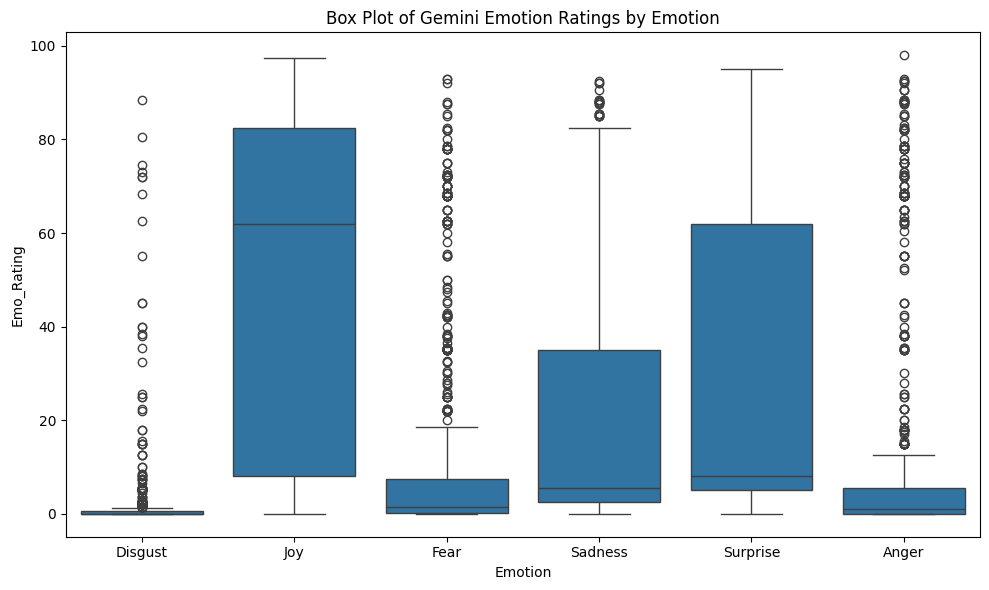

In [27]:
box_plot(llm_df,'Gemini')

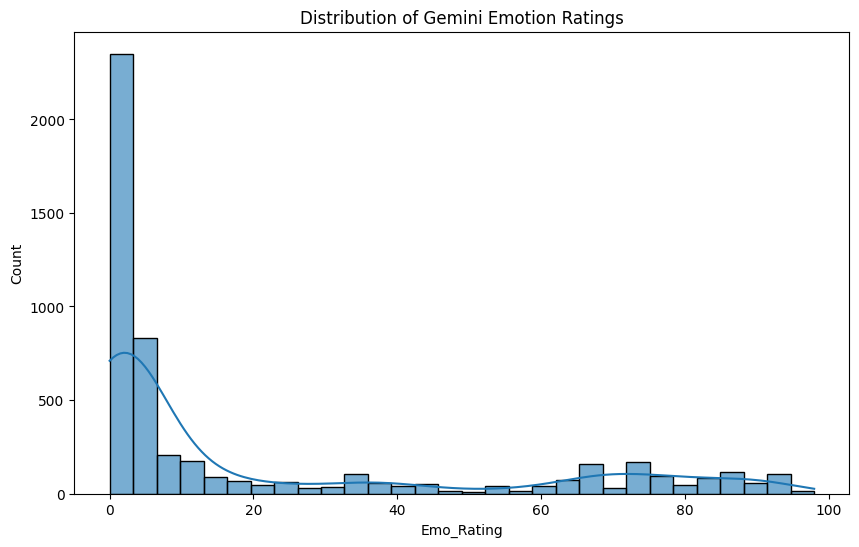

In [28]:
overall_histogram(llm_df, 'Gemini')

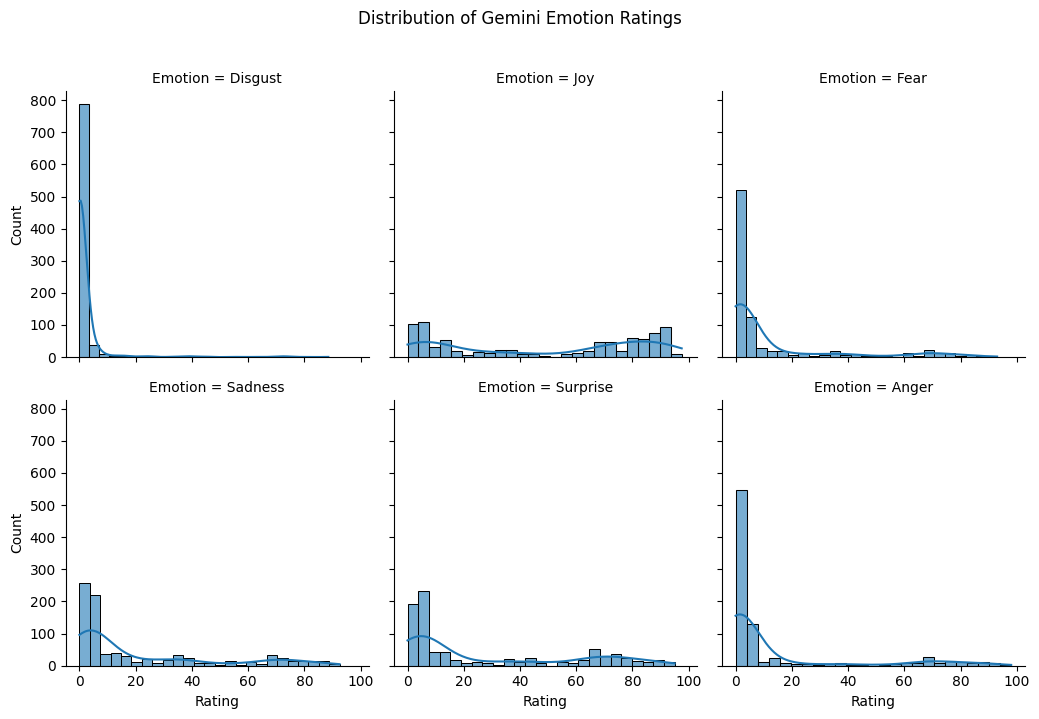

In [29]:
emotion_histogram(llm_df, 'Gemini')

In [30]:
emotion_skewness(llm_df, 'Gemini')

Skewness of Gemini Emotion Ratings:
Disgust: skewness = 6.867
Joy: skewness = -0.133
Fear: skewness = 2.130
Sadness: skewness = 1.301
Surprise: skewness = 0.818
Anger: skewness = 2.066


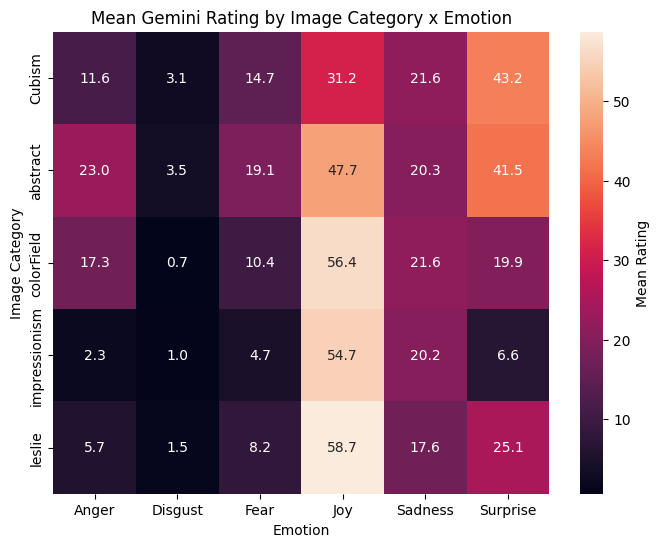

In [31]:
image_category_heatmap(llm_df, 'Gemini')

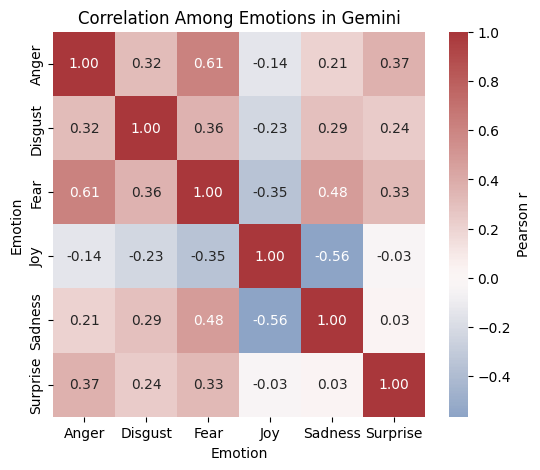

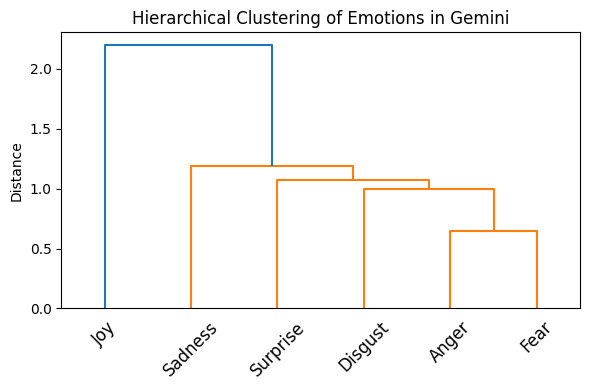

In [32]:
emotion_category(llm_df, 'Gemini')

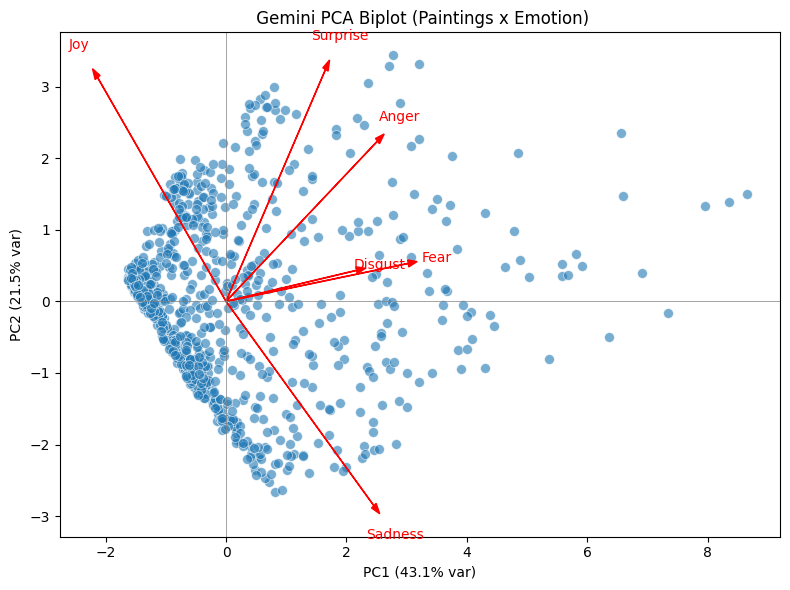

In [33]:
pca_biplot(llm_df, 'Gemini')

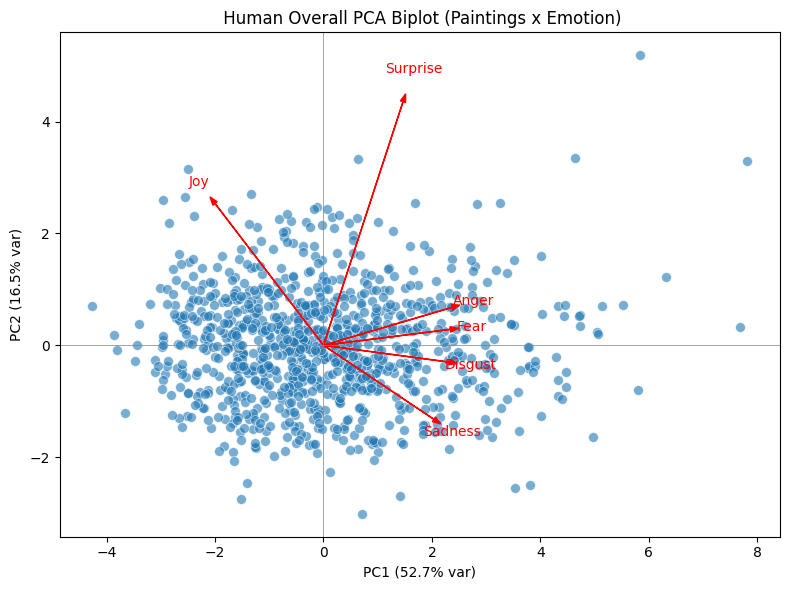

In [34]:
pca_biplot(human_df, 'Human Overall')

### Now Compare Human vs LLM data

In [35]:
human_df['n_ratings'] = (
    human_df
      .groupby(['image','Emotion'])['emo_rating']
      .transform('count')
)

In [36]:
human_df

participant                                         image  \
0         8685107.0                        140abstract.jpg_leslie   
1         8685107.0                           141woman.jpg_leslie   
2         8685107.0                           145banjo.jpg_leslie   
3         8685107.0                          151guitar.jpg_leslie   
4         8685107.0                        170abstract.jpg_leslie   
...             ...                                           ...   
125072   13458459.0              la-jolla-arbor.jpg_impressionism   
125073   13458459.0  lake-in-the-mountains-1899.jpg_impressionism   
125074   13458459.0              not_detected_189365.jpg_abstract   
125075   13458459.0              not_detected_189367.jpg_abstract   
125076   13458459.0                        taboo-19631.jpg_Cubism   

       image_category   Emotion  emo_rating  n_ratings  
0              leslie     Anger        78.0         24  
1              leslie     Anger        25.0         17  
2              leslie     Anger         0.0         24  
3              leslie     Anger        60.0         46  
4              leslie     Anger        60.0         15  
...               ...       ...         ...        ...  
125072  impressionism  Surprise        11.0         14  
125073  impressionism  Surprise        12.0         28  
125074       abstract  Surprise        11.0        107  
125075       abstract  Surprise        10.0        107  
125076         Cubism  Surprise        10.0        106  

[125077 rows x 6 columns]

In [37]:
human_df[(human_df['image']=='140abstract.jpg_leslie')&(human_df['Emotion']=='Anger')]

participant                   image image_category Emotion  \
0         8685107.0  140abstract.jpg_leslie         leslie   Anger   
28438    11140955.0  140abstract.jpg_leslie         leslie   Anger   
30052    11140988.0  140abstract.jpg_leslie         leslie   Anger   
32488    11140995.0  140abstract.jpg_leslie         leslie   Anger   
36526    11141005.0  140abstract.jpg_leslie         leslie   Anger   
38146    11141013.0  140abstract.jpg_leslie         leslie   Anger   
40570    11141039.0  140abstract.jpg_leslie         leslie   Anger   
47854    11141112.0  140abstract.jpg_leslie         leslie   Anger   
48658    11141120.0  140abstract.jpg_leslie         leslie   Anger   
53500    11141206.0  140abstract.jpg_leslie         leslie   Anger   
55924    11141321.0  140abstract.jpg_leslie         leslie   Anger   
61582    11141654.0  140abstract.jpg_leslie         leslie   Anger   
67258    11141993.0  140abstract.jpg_leslie         leslie   Anger   
68866    11142194.0  140abstract.jpg_leslie         leslie   Anger   
77770    11178599.0  140abstract.jpg_leslie         leslie   Anger   
79384    11208287.0  140abstract.jpg_leslie         leslie   Anger   
87783    13389743.0  140abstract.jpg_leslie         leslie   Anger   
91608    13425391.0  140abstract.jpg_leslie         leslie   Anger   
98312    13433165.0  140abstract.jpg_leslie         leslie   Anger   
100224   13433177.0  140abstract.jpg_leslie         leslie   Anger   
104053   13457099.0  140abstract.jpg_leslie         leslie   Anger   
112665   13457212.0  140abstract.jpg_leslie         leslie   Anger   
116491   13457328.0  140abstract.jpg_leslie         leslie   Anger   
119361   13457484.0  140abstract.jpg_leslie         leslie   Anger   

        emo_rating  n_ratings  
0             78.0         24  
28438          0.0         24  
30052         73.0         24  
32488          5.0         24  
36526          1.0         24  
38146          0.0         24  
40570          2.0         24  
47854         22.0         24  
48658          1.0         24  
53500          0.0         24  
55924         13.0         24  
61582          3.0         24  
67258         37.0         24  
68866          2.0         24  
77770         68.0         24  
79384         52.0         24  
87783          8.0         24  
91608         32.0         24  
98312         21.0         24  
100224         5.0         24  
104053         3.0         24  
112665       100.0         24  
116491         6.0         24  
119361         0.0         24

In [38]:
variation_stats = (
    human_df
      .groupby(['image','Emotion'])['emo_rating']
      .agg(
         count='count',      # number of ratings
         mean='mean',        # average rating
         std='std',          # standard deviation
         var='var',          # variance
         min='min',          # lowest rating
         max='max',          # highest rating
         q1=lambda x: x.quantile(0.25),  # 1st quartile
         q3=lambda x: x.quantile(0.75)   # 3rd quartile
      )
      .reset_index()
)

print(variation_stats.head())


                               image  Emotion  count       mean        std  \
0  01Klimt-Beethovenfries.png_leslie    Anger     15  14.666667  22.366003   
1  01Klimt-Beethovenfries.png_leslie  Disgust     22  36.045455  35.652392   
2  01Klimt-Beethovenfries.png_leslie     Fear     18  14.222222  22.356880   
3  01Klimt-Beethovenfries.png_leslie      Joy     16  40.125000  35.633084   
4  01Klimt-Beethovenfries.png_leslie  Sadness     19  18.894737  19.461914   

           var  min    max    q1     q3  
0   500.238095  0.0   72.0  0.50  20.00  
1  1271.093074  0.0  100.0  2.75  61.50  
2   499.830065  0.0   86.0  0.25  19.25  
3  1269.716667  1.0  100.0  6.50  69.25  
4   378.766082  0.0   53.0  0.00  31.50  


In [39]:
#calculate weighted average score per image per emotion for human rating
human_avg_df = (
    human_df
      .groupby(['image','image_category','Emotion'])
      .apply(lambda g: np.average(g['emo_rating'], weights=g['n_ratings']))
      .reset_index(name='emo_rating')
)

human_avg_df

/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_51559/2404198638.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g['emo_rating'], weights=g['n_ratings']))


image image_category   Emotion  emo_rating
0     01Klimt-Beethovenfries.png_leslie         leslie     Anger   14.666667
1     01Klimt-Beethovenfries.png_leslie         leslie   Disgust   36.045455
2     01Klimt-Beethovenfries.png_leslie         leslie      Fear   14.222222
3     01Klimt-Beethovenfries.png_leslie         leslie       Joy   40.125000
4     01Klimt-Beethovenfries.png_leslie         leslie   Sadness   18.894737
...                                 ...            ...       ...         ...
5796               zinc-1917.jpg_Cubism         Cubism   Disgust   23.576923
5797               zinc-1917.jpg_Cubism         Cubism      Fear   25.571429
5798               zinc-1917.jpg_Cubism         Cubism       Joy   30.269231
5799               zinc-1917.jpg_Cubism         Cubism   Sadness   35.892857
5800               zinc-1917.jpg_Cubism         Cubism  Surprise   36.586207

[5801 rows x 4 columns]

Top 10 images by standard deviation per emotion:
     Emotion                                              image        std
0      Anger                      untitled-2012-71.jpg_abstract  39.585027
1      Anger         variation-z-rtlichkeiten-1917.jpg_abstract  39.571422
2      Anger                          elements-v.jpg_colorField  39.418116
3      Anger                                 78imari.jpg_leslie  39.405342
4      Anger                    beta-lambda-1961.jpg_colorField  38.694217
5      Anger                            red-jew-1915.jpg_Cubism  38.382432
6      Anger                        citadel-1962.jpg_colorField  38.318001
7      Anger                           self-portrait.jpg_Cubism  38.267480
8      Anger                           alya-1964.jpg_colorField  37.896451
9      Anger                      canto-xiv-1964.jpg_colorField  37.440024
10   Disgust          composizione-in-azzurro-1965.jpg_abstract  38.789252
11   Disgust                    untitled-1985-11.jp

/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_51559/1304069170.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(10, 'std'))


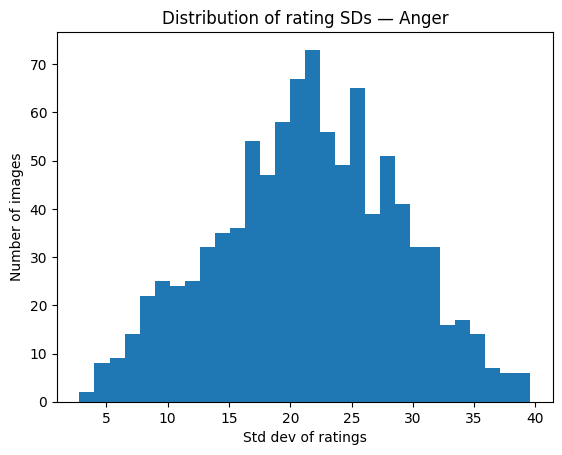

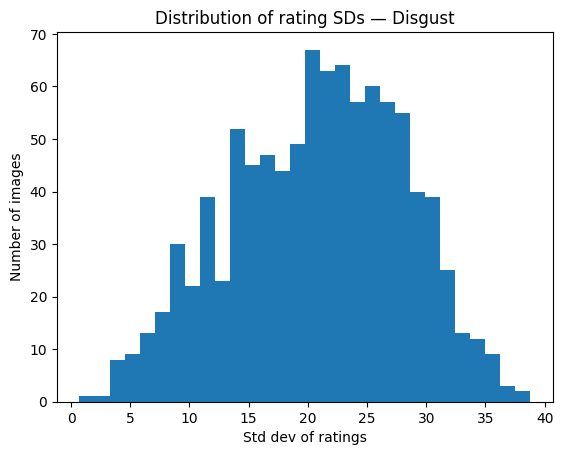

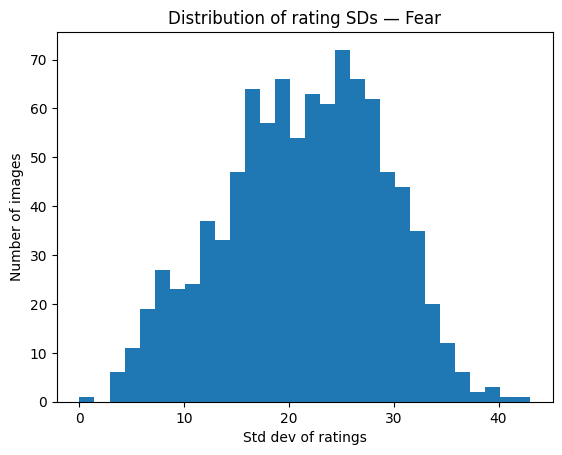

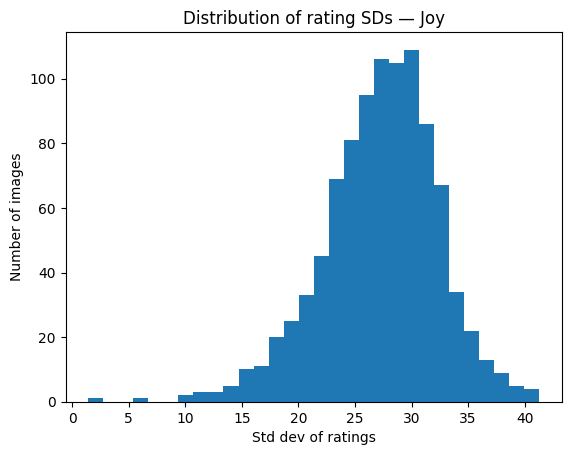

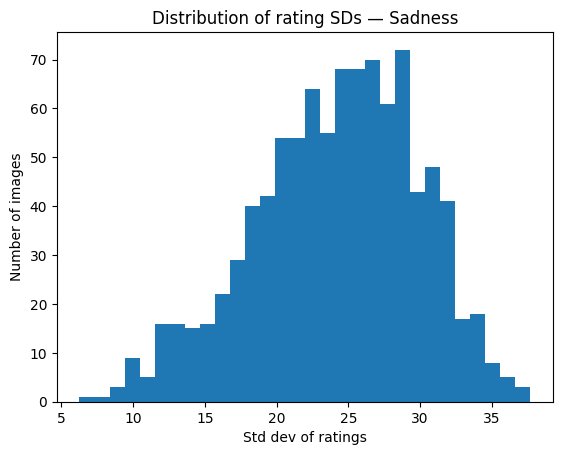

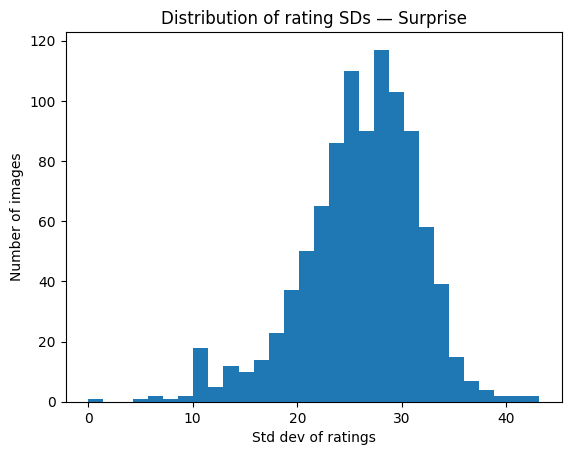

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Compute count, mean, and SD per image × emotion
variation_stats = (
    human_df
      .groupby(['image','Emotion'])['emo_rating']
      .agg(
         count='count',
         mean='mean',
         std='std'
      )
      .reset_index()
)

# 2. Look at the top 10 most-disagreed images for each emotion
top_var = (
    variation_stats
      .dropna(subset=['std'])                # drop groups with <2 ratings
      .groupby('Emotion')
      .apply(lambda g: g.nlargest(10, 'std'))
      .reset_index(drop=True)
)

print("Top 10 images by standard deviation per emotion:")
print(top_var[['Emotion','image','std']])


# 3. Plot the spread of SDs across images for each emotion
for emo in variation_stats['Emotion'].unique():
    stds = variation_stats.loc[
        variation_stats['Emotion']==emo, 'std'
    ].dropna()
    plt.figure()
    plt.hist(stds, bins=30)
    plt.xlabel('Std dev of ratings')
    plt.ylabel('Number of images')
    plt.title(f'Distribution of rating SDs — {emo}')
    plt.show()


### EDA for Average Human data

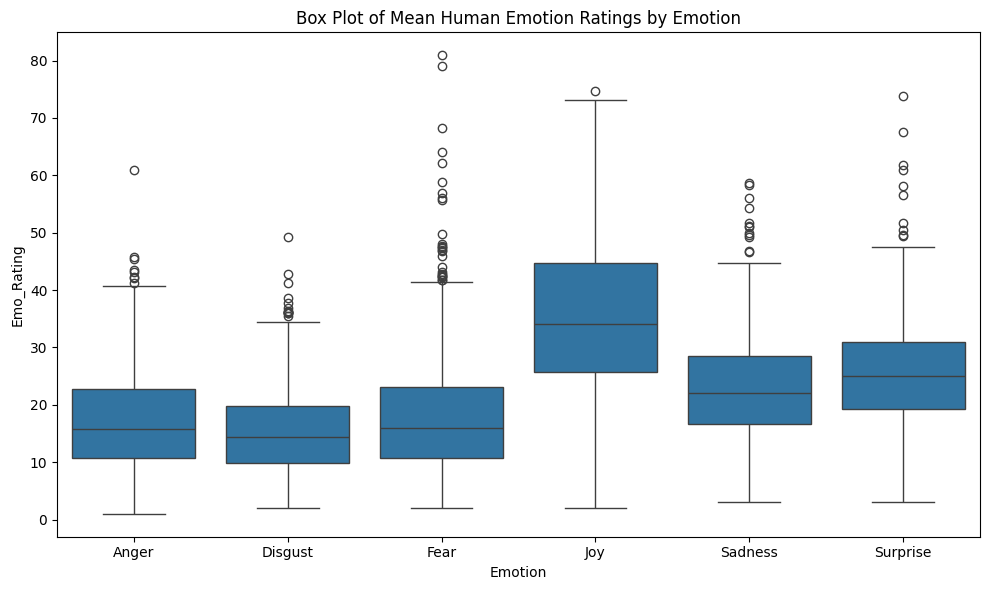

In [41]:
box_plot(human_avg_df,'Mean Human')

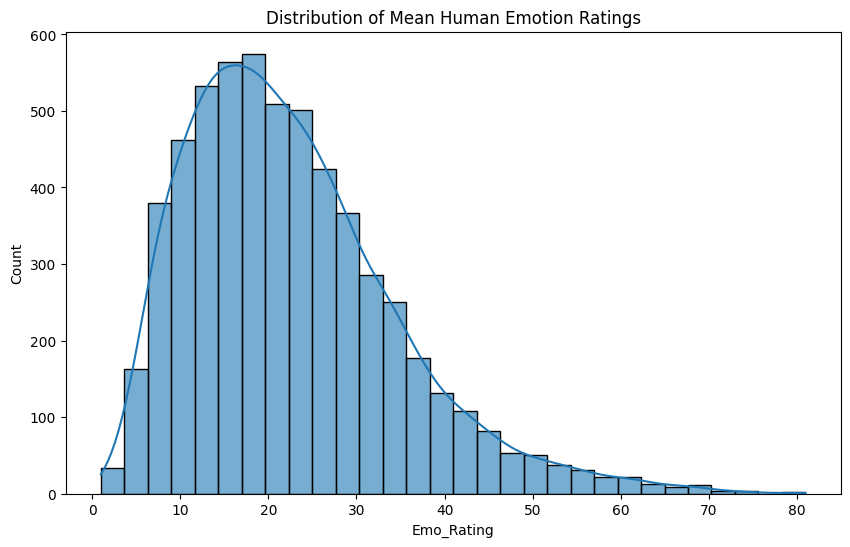

In [42]:
overall_histogram(human_avg_df,'Mean Human')

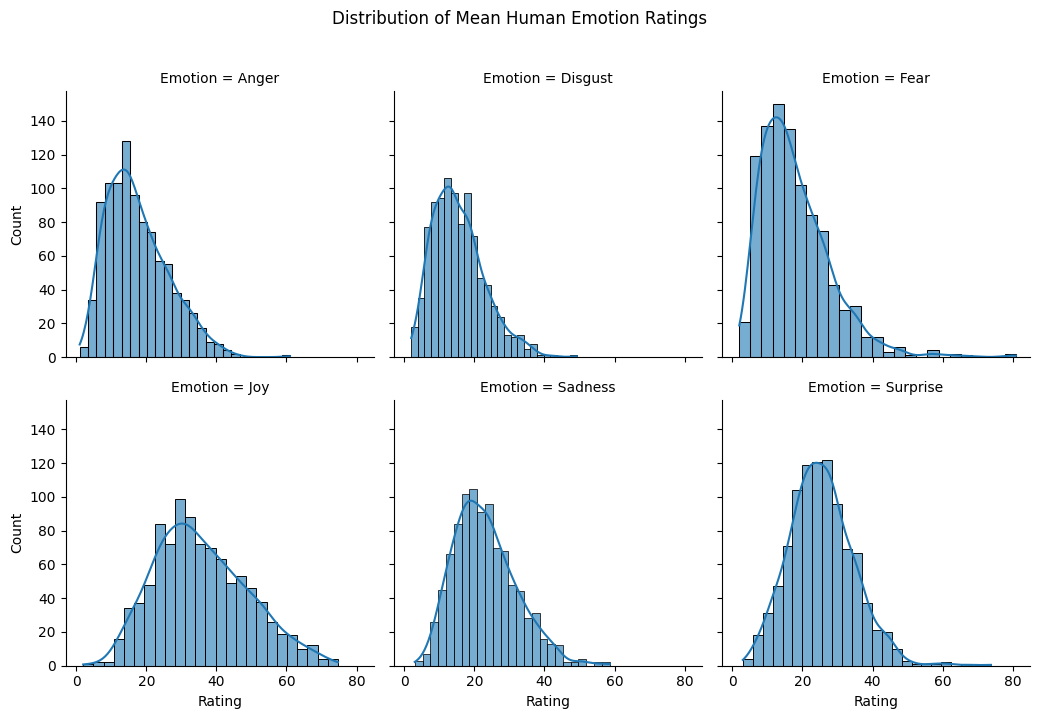

In [43]:
emotion_histogram(human_avg_df,'Mean Human')

In [44]:
emotion_skewness(human_avg_df, 'Human Average')

Skewness of Human Average Emotion Ratings:
Anger: skewness = 0.770
Disgust: skewness = 0.783
Fear: skewness = 1.551
Joy: skewness = 0.415
Sadness: skewness = 0.677
Surprise: skewness = 0.567


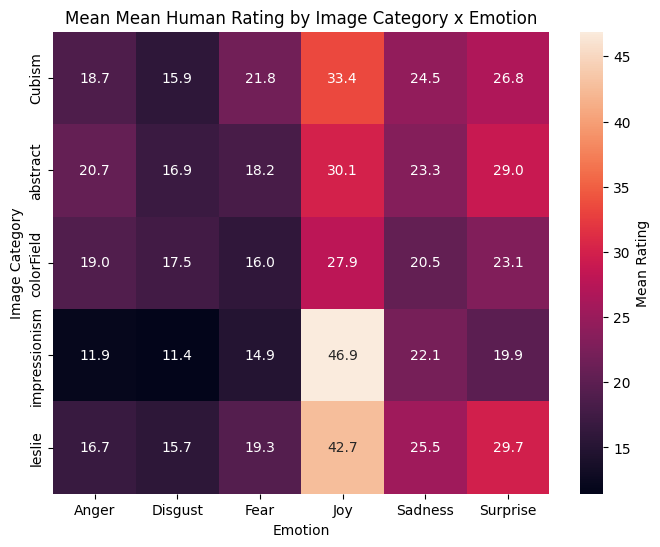

In [45]:
image_category_heatmap(human_avg_df,'Mean Human')

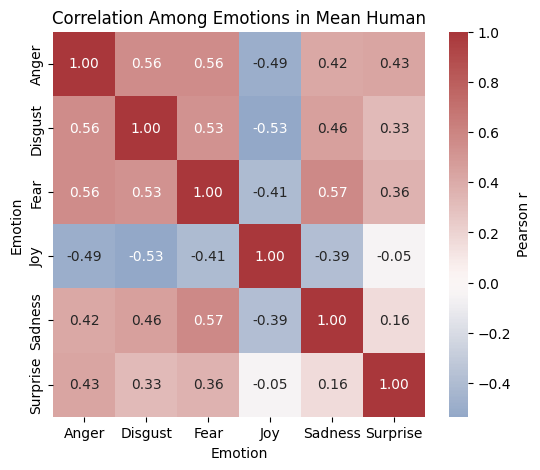

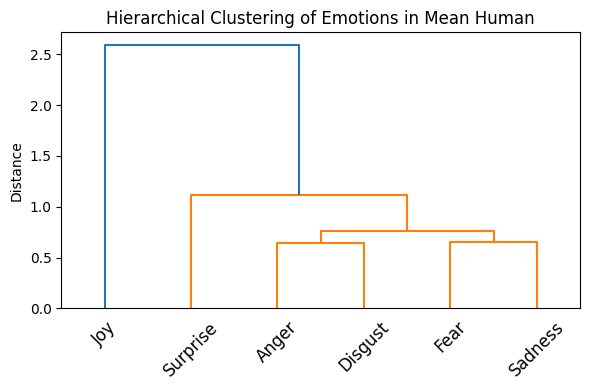

In [46]:
emotion_category(human_avg_df,'Mean Human')

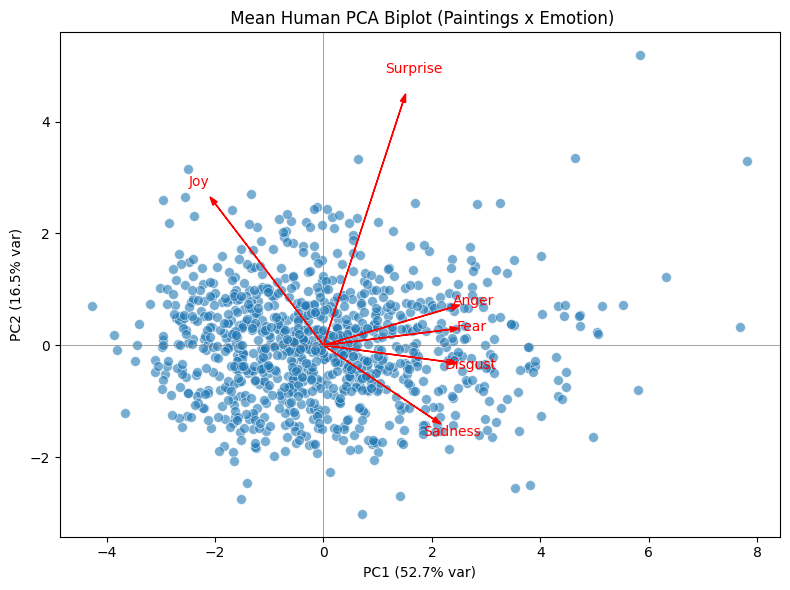

In [47]:
pca_biplot(human_avg_df,'Mean Human')

In [48]:
#match images that are present in both human and LLM ratings
common = set(human_avg_df['image']).intersection(llm_df['image'])
human_sub = human_avg_df[human_avg_df['image'].isin(common)]
llm_sub   = llm_df[llm_df['image'].isin(common)]


In [49]:
#merge human and LLM df
merged_rating = pd.merge(
    human_sub,
    llm_sub,
    on=['image','Emotion'],
    suffixes=('_human','_llm')
)
# merged now has columns: image, Emotion, human_rating, llm_rating
merged_rating = merged_rating.dropna(subset=['emo_rating_human', 'emo_rating_llm'])

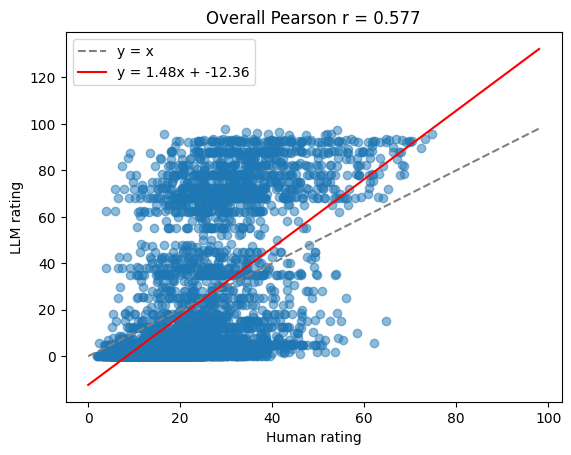

Anger: r = 0.410


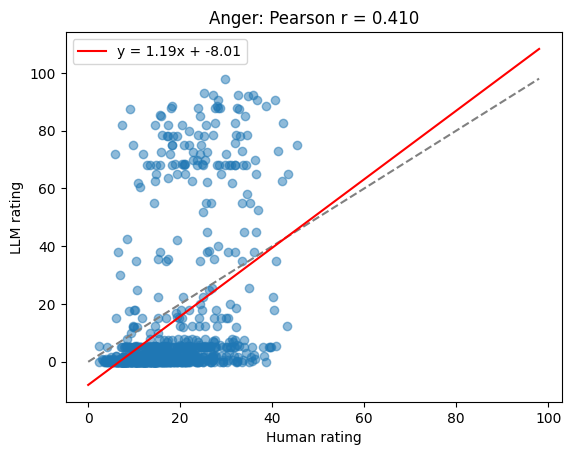

Disgust: r = 0.179


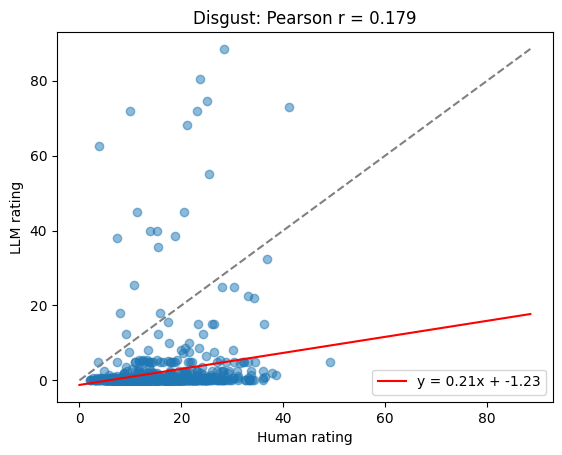

Fear: r = 0.468


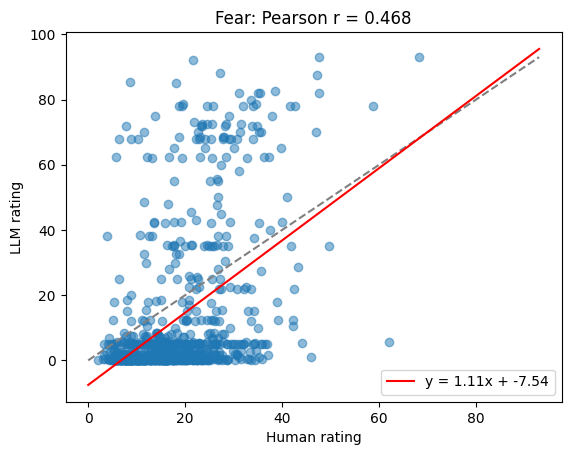

Joy: r = 0.412


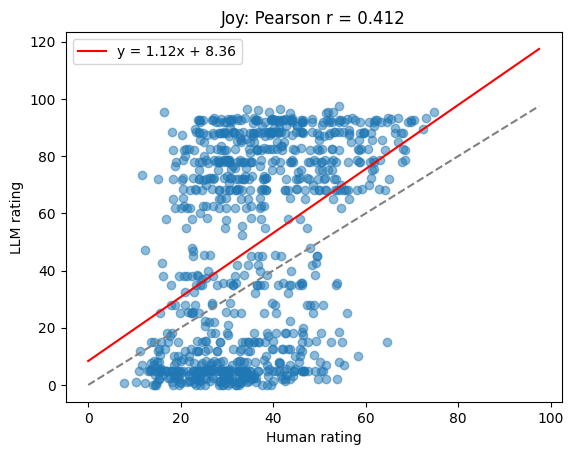

Sadness: r = 0.507


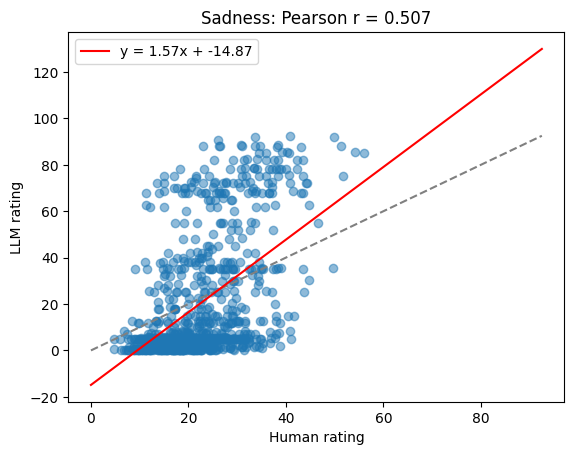

Surprise: r = 0.385


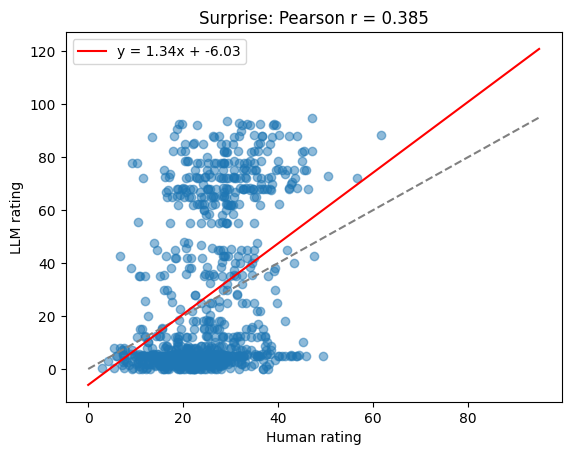

In [50]:
pearson_correlation_plot(merged_rating)

### Check Correlation after dropping 0 rating scores

In [52]:
merged_rating_nonZero = merged_rating[(merged_rating['emo_rating_human'] != 0) & (merged_rating['emo_rating_llm'] != 0)].reset_index(drop=True)

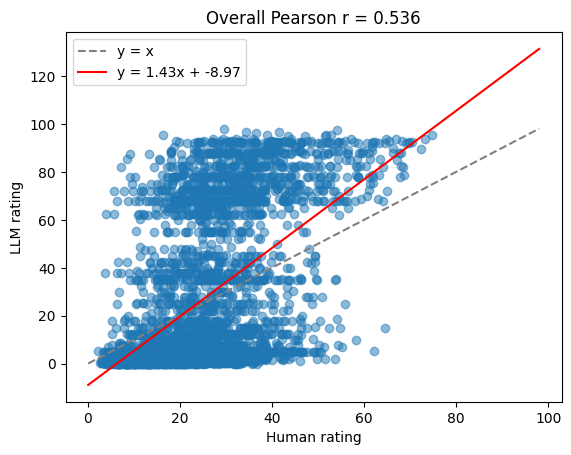

Anger: r = 0.374


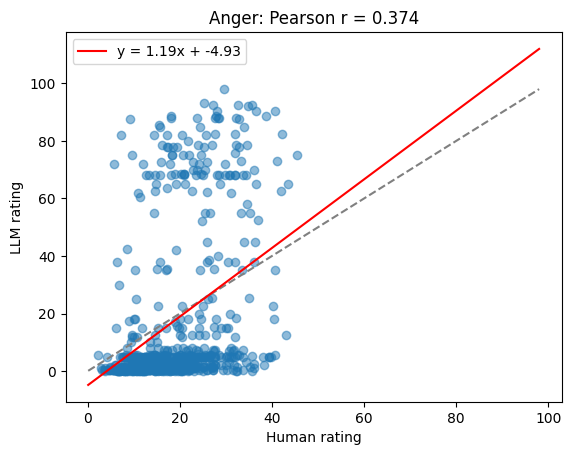

Fear: r = 0.450


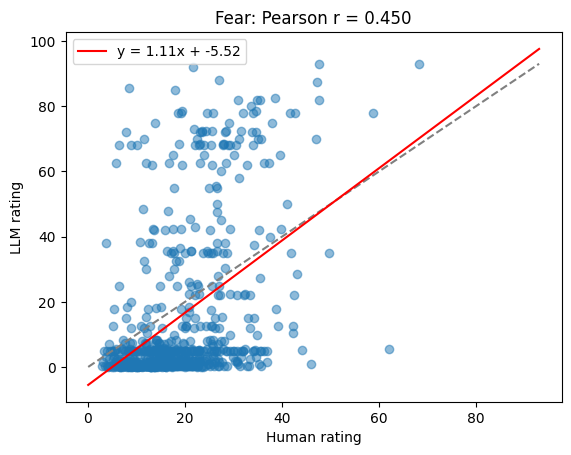

Joy: r = 0.406


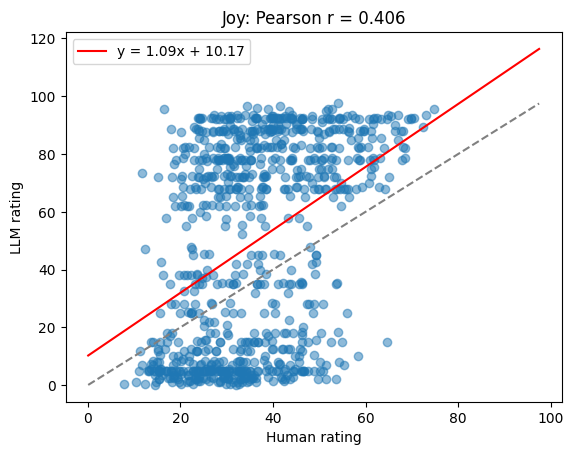

Sadness: r = 0.490


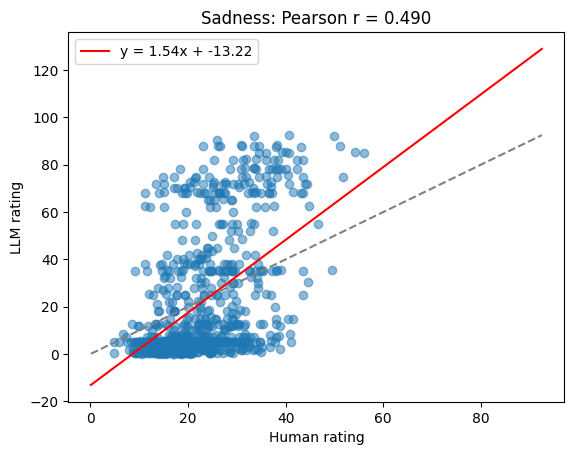

Surprise: r = 0.382


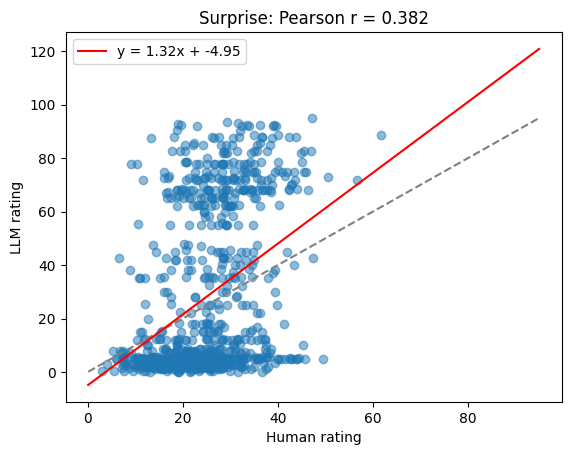

Disgust: r = 0.168


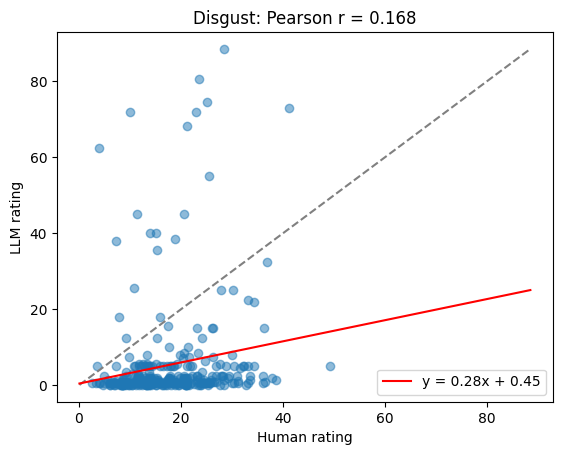

In [53]:
pearson_correlation_plot(merged_rating_nonZero)

### Check liking correlation

In [77]:
liking_cols = cols = ['Participant_Private','Image Name', 'Image Category', 'Emotion', 'Emo_Rating','Liking_Rating']
temp_df = exp3_rating[liking_cols].copy()
temp_df.rename(columns={
    'Participant_Private': 'participant',
    'Image Name':         'image',
    'Image Category':     'image_category',
    'Emo_Rating':         'emo_rating',
    'Liking_Rating':      'liking_rating'
}, inplace=True)

In [78]:
#collapse liknig into emo_rating
df_main = temp_df.drop(columns=['liking_rating'])

df_liking = temp_df.copy()
df_liking['Emotion']    = 'Liking'
df_liking['emo_rating'] = df_liking['liking_rating']
df_liking = df_liking.drop(columns=['liking_rating'])

human_liking = pd.concat([df_main, df_liking], ignore_index=True, sort=False)

In [79]:
human_liking['image'] = (
    human_liking['image'].astype(str)
    + '_'
    + human_liking['image_category'].astype(str)
)

In [80]:
human_liking

participant                                         image  \
0         13339281                       2005-60-80.jpg_abstract   
1         13339281             a-time-to-turn-48x48.jpg_abstract   
2         13339281            abstraccion-no-3-1953.jpg_abstract   
3         13339281                    abstract-1940.jpg_abstract   
4         13339281       abstract-composition-19151.jpg_abstract   
...            ...                                           ...   
89789     13458459              la-jolla-arbor.jpg_impressionism   
89790     13458459  lake-in-the-mountains-1899.jpg_impressionism   
89791     13458459              not_detected_189365.jpg_abstract   
89792     13458459              not_detected_189367.jpg_abstract   
89793     13458459                        taboo-19631.jpg_Cubism   

      image_category Emotion  emo_rating  
0           abstract   Anger         3.0  
1           abstract   Anger        10.0  
2           abstract   Anger         2.0  
3           abstract   Anger        11.0  
4           abstract   Anger         0.0  
...              ...     ...         ...  
89789  impressionism  Liking        61.0  
89790  impressionism  Liking        28.0  
89791       abstract  Liking        46.0  
89792       abstract  Liking        68.0  
89793         Cubism  Liking        31.0  

[89794 rows x 5 columns]

In [81]:
#weighted average score per image per emotion for human liking
human_liking['n_ratings'] = (
    human_liking
      .groupby(['image','Emotion'])['emo_rating']
      .transform('count')
)

human_avg_liking = (
    human_liking
      .groupby(['image','image_category','Emotion'])
      .apply(lambda g: np.average(g['emo_rating'], weights=g['n_ratings']))
      .reset_index(name='emo_rating')
)


/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_51559/2786847809.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g['emo_rating'], weights=g['n_ratings']))


In [82]:
llm_liking = llm_concat_ratings

In [83]:
llm_liking['image'] = (
    llm_liking['image'].astype(str)
    + '_'
    + llm_liking['image_category'].astype(str)
)

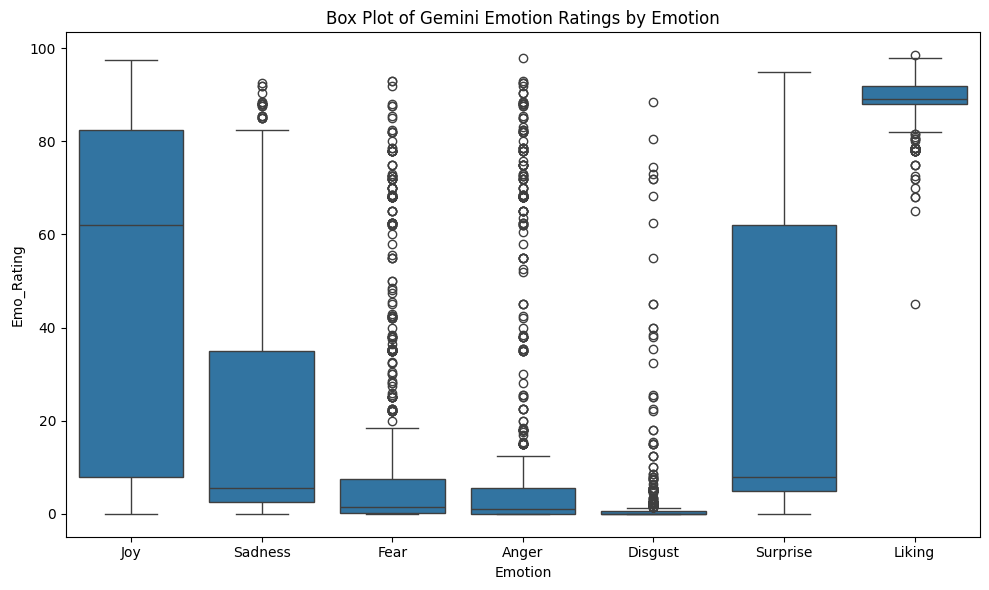

In [106]:
box_plot(llm_liking, 'Gemini')

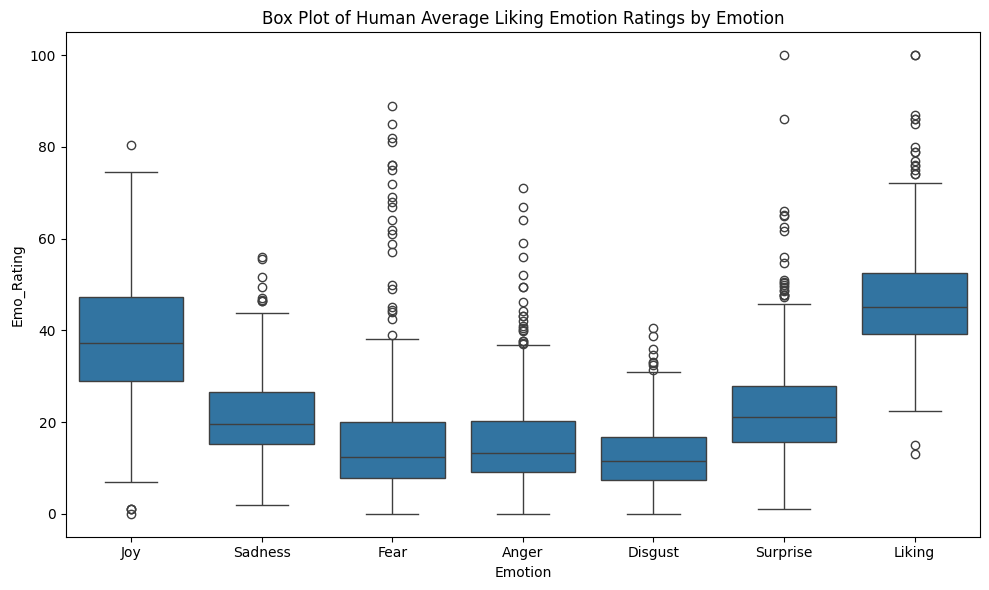

In [107]:
box_plot(human_avg_liking,'Human Average Liking')

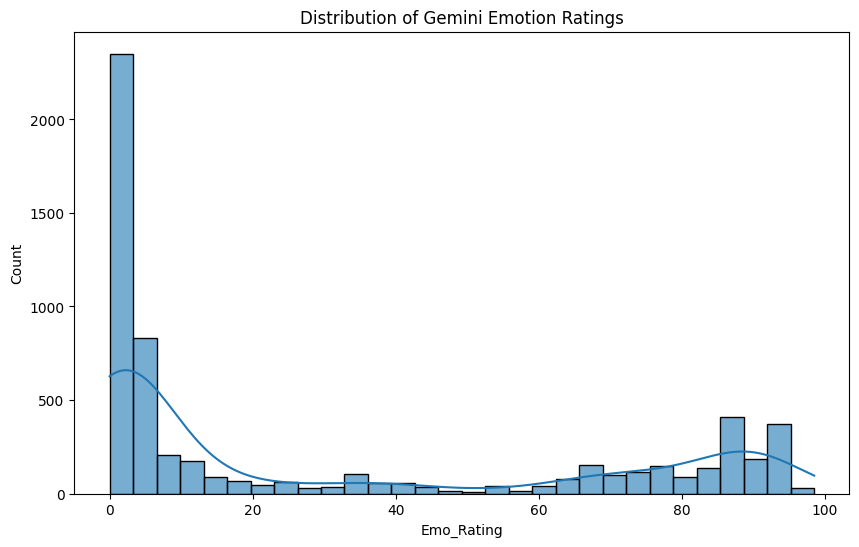

In [127]:
overall_histogram(llm_liking, 'Gemini')

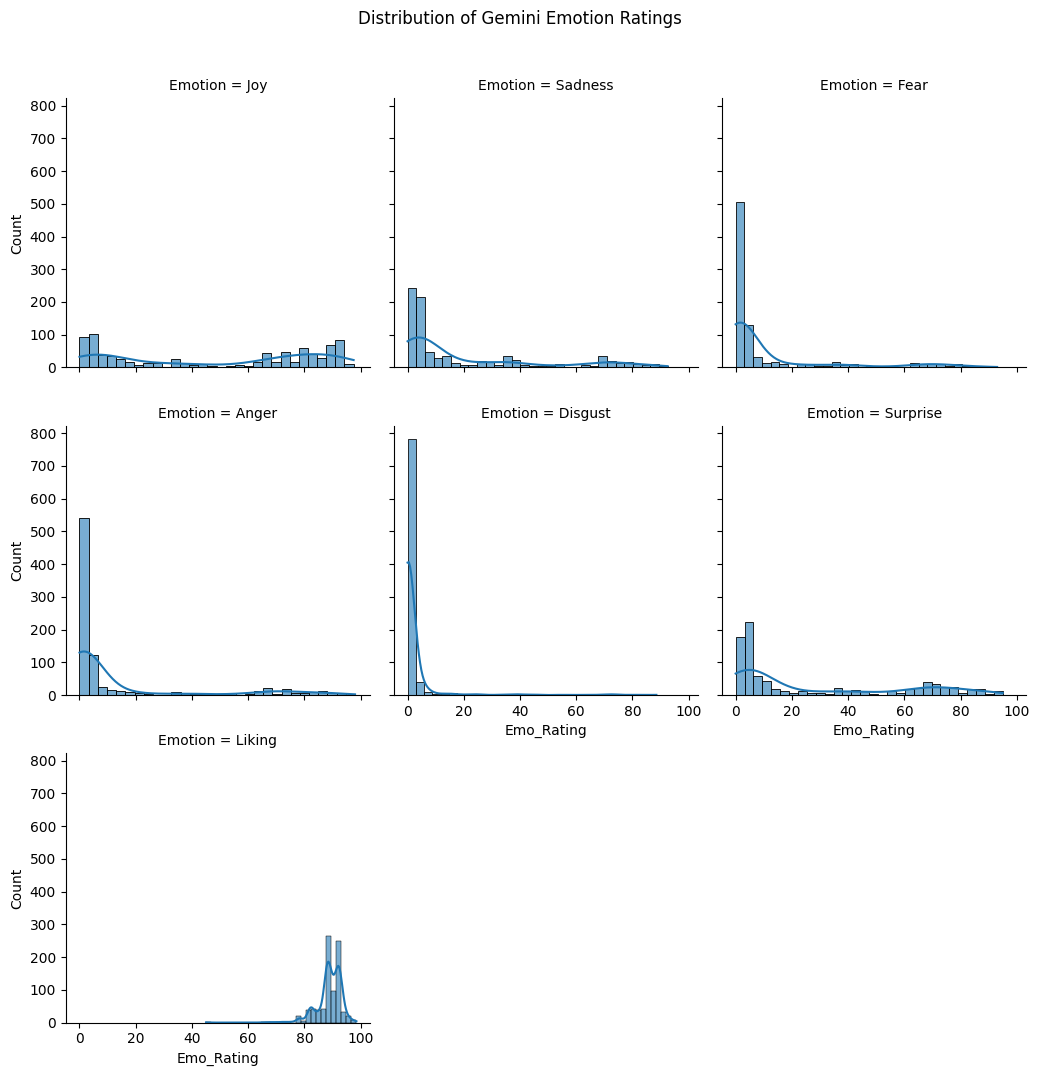

In [121]:
emotion_histogram(llm_liking, 'Gemini')

In [110]:
emotion_skewness(llm_df, 'Gemini') 

Skewness of Gemini Emotion Ratings:
Disgust: skewness = 6.867
Joy: skewness = -0.133
Fear: skewness = 2.130
Sadness: skewness = 1.301
Surprise: skewness = 0.818
Anger: skewness = 2.066


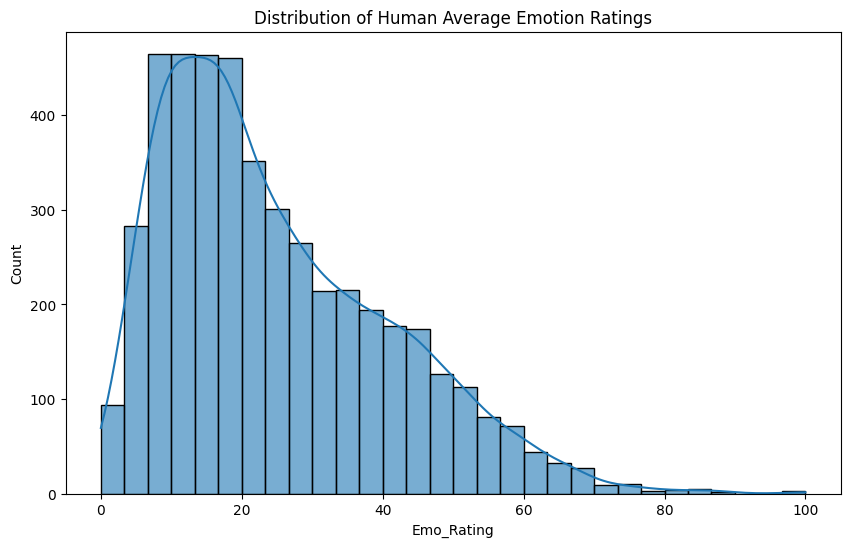

In [124]:
overall_histogram(human_avg_liking,'Human Average')

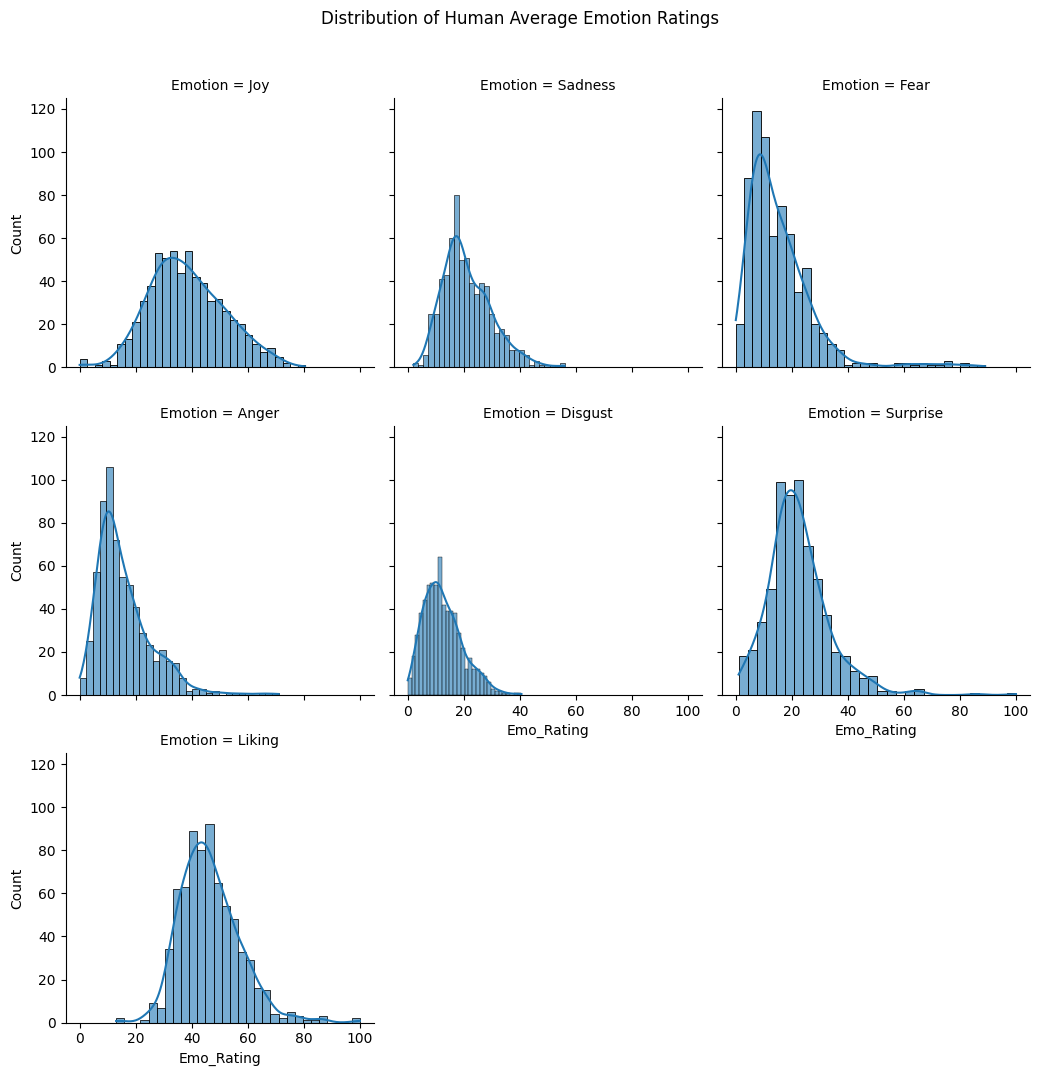

In [122]:
emotion_histogram(human_avg_liking,'Human Average')

In [114]:
emotion_skewness(human_avg_liking, 'Human Average Liking')

Skewness of Human Average Liking Emotion Ratings:
Disgust: skewness = 0.779
Liking: skewness = 0.884
Surprise: skewness = 1.477
Anger: skewness = 1.615
Fear: skewness = 2.550
Joy: skewness = 0.272
Sadness: skewness = 0.805


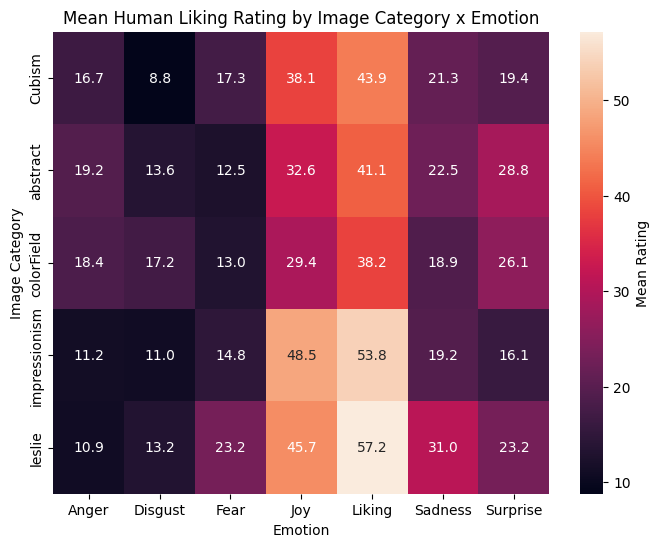

In [84]:
image_category_heatmap(human_avg_liking, 'Human Liking')

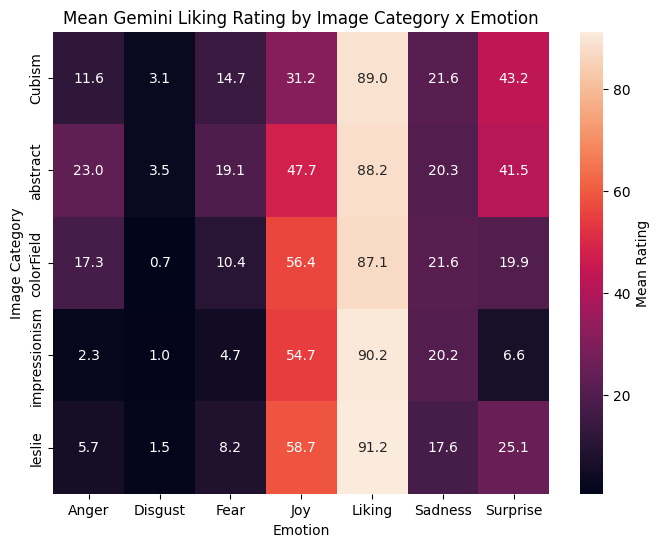

In [85]:
image_category_heatmap(llm_liking, 'Gemini Liking')

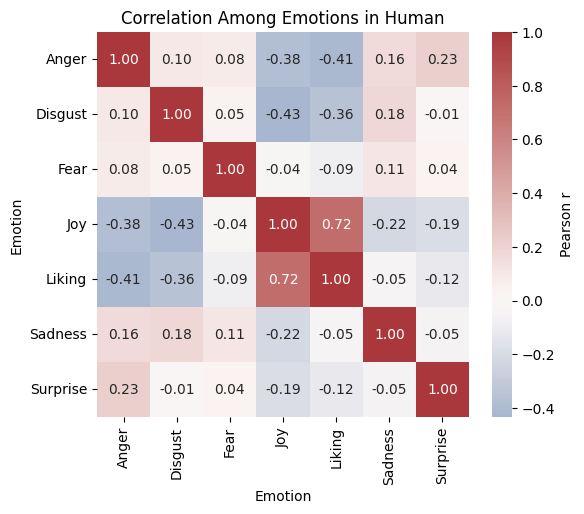

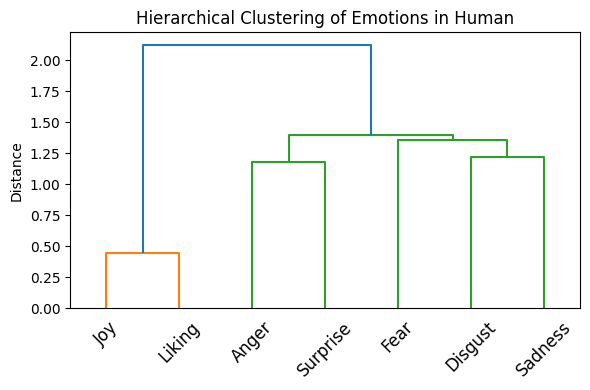

In [86]:
emotion_category(human_avg_liking, 'Human')

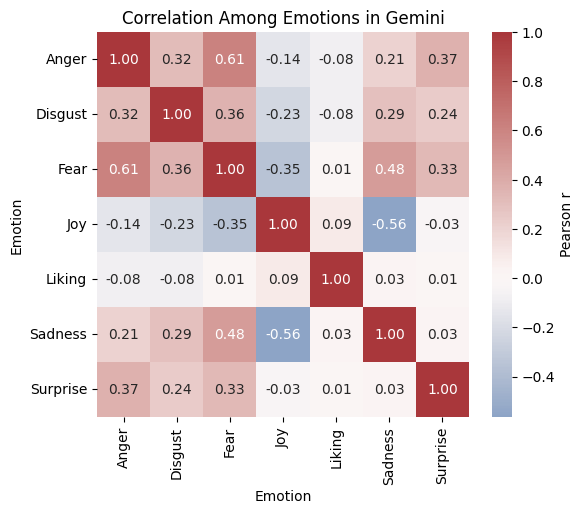

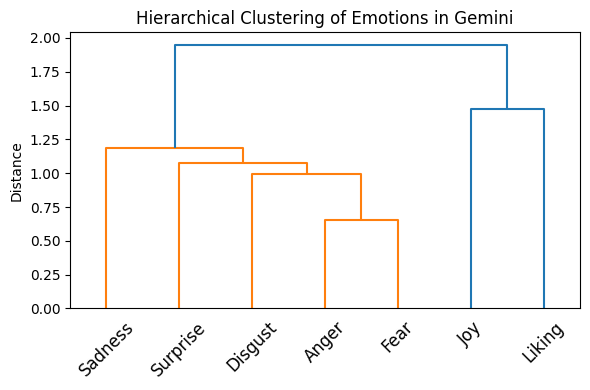

In [87]:
emotion_category(llm_liking, 'Gemini')

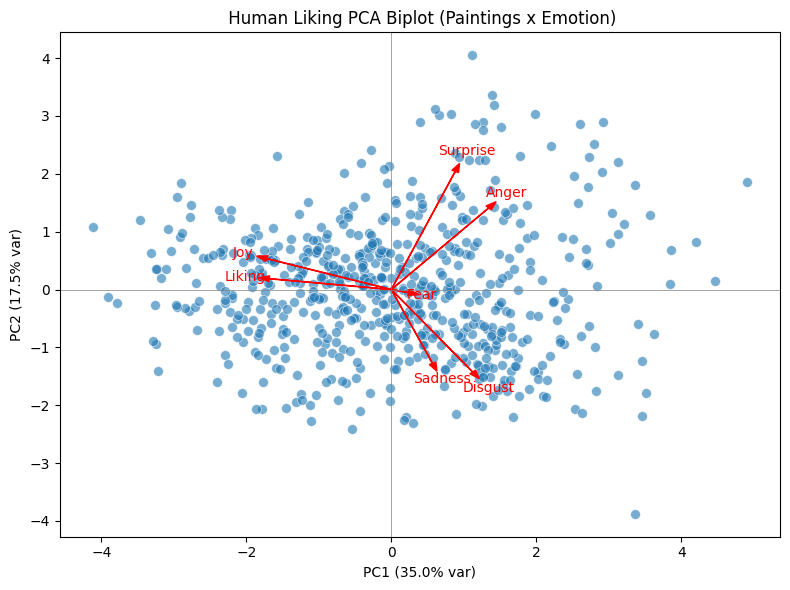

In [90]:
pca_biplot(human_avg_liking, 'Human Liking')

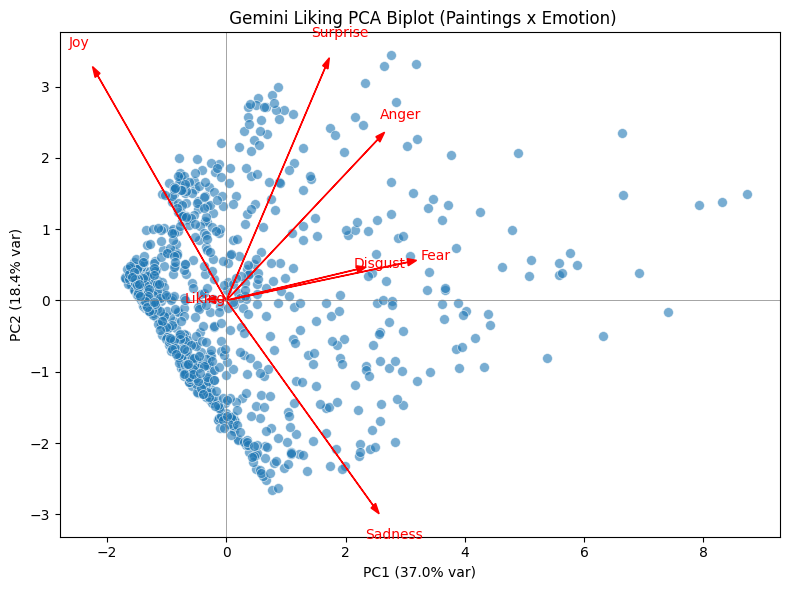

In [91]:
pca_biplot(llm_liking, 'Gemini Liking')

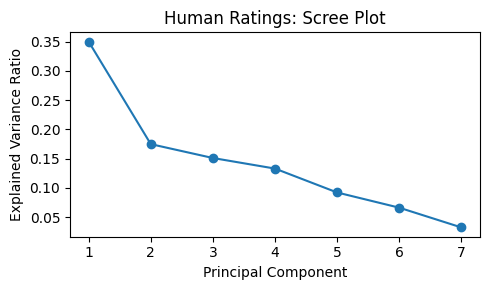

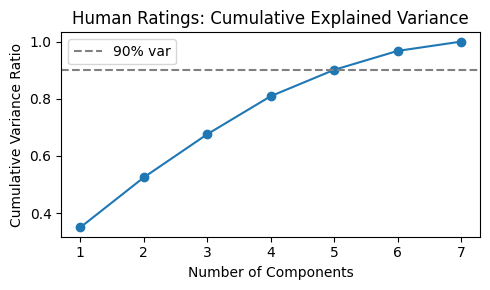

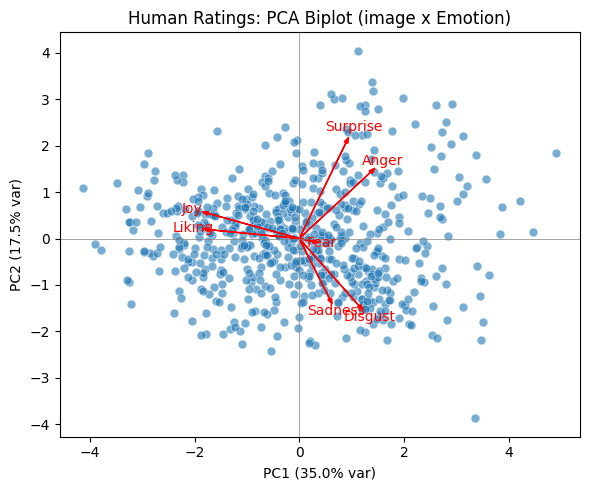

In [92]:
# 1) PCA on individual images, keep all possible PCs
pca_img, coords_img = pca_analysis(
    human_avg_liking, 'Human Ratings', group_key='image', n_components=7
)



In [93]:
coords_img

image       PC1       PC2  \
0        02Dali-PersistenceOfMemoryclocks_1.png_leslie  0.888677 -2.144928   
1    03Klimt-TheVirgin11620the20virgin201913.jpg_le...  0.168160  0.022459   
2                   05Klimt-TheKissj6hj3k43.png_leslie -0.835428 -1.551952   
3                          07Monet-nympheas.jpg_leslie -2.785474 -0.376769   
4    08Dali-MetamorphosedeNarcisset02343_10.jpg_leslie  1.023791 -1.250437   
..                                                 ...       ...       ...   
621         young-girl-in-the-fields.jpg_impressionism -1.773723 -1.604492   
622  young-woman-in-a-garden-cagnes-1905.jpg_impres... -1.620187 -1.043462   
623                          zebra-1969.jpg_colorField -1.392336  0.697960   
624                zimsko-jutro-1911.jpg_impressionism  0.178254 -2.254414   
625                               zinc-1917.jpg_Cubism  1.770352  1.141347   

          PC3       PC4       PC5       PC6       PC7  
0   -0.044042  3.766031  0.371629  0.394757 -0.022429  
1   -1.029898  0.343825 -0.338621 -0.073920 -0.749997  
2   -1.439677  1.335489  1.036230 -0.000762  0.148872  
3   -0.254722  1.635695  0.633156  0.303054 -0.086260  
4    0.539651  2.393543  1.295667 -0.058098 -0.229636  
..        ...       ...       ...       ...       ...  
621  0.150690  1.321216 -0.809390  0.177783  0.698837  
622  0.429207  0.961780 -0.577299  1.312604  0.291936  
623  0.226352 -1.715357  0.101802 -0.636817  1.355471  
624  0.330755  1.636530 -1.140816 -0.056477  0.598881  
625  0.130178  0.951173 -1.226199  0.534901  0.229108  

[626 rows x 8 columns]

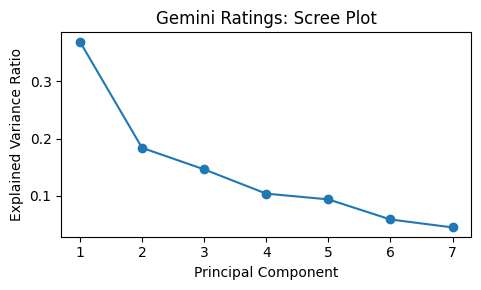

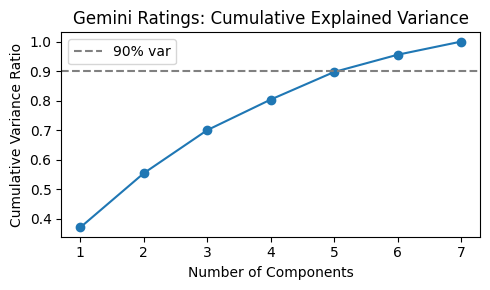

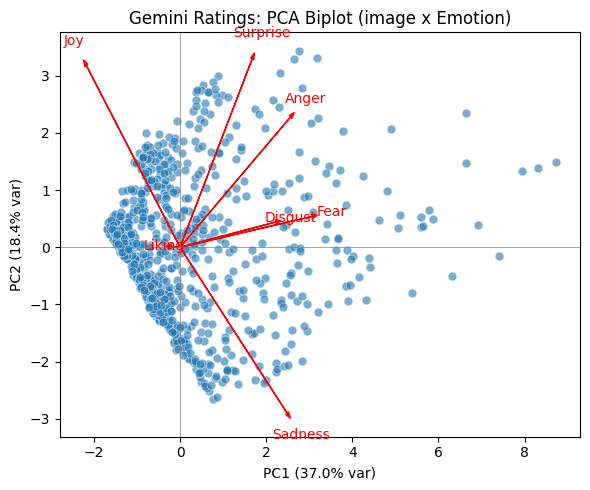

In [94]:
pca_llm_img, coords_llm_img = pca_analysis(
    llm_liking, 'Gemini Ratings', group_key='image', n_components=7
)

In [95]:
#merge LLM and human avg liking Df
common = set(human_avg_liking['image']).intersection(llm_liking['image'])
human_avg_liking_sub = human_avg_liking[human_avg_liking['image'].isin(common)]
llm_liking_sub   = llm_liking[llm_liking['image'].isin(common)]

merged_liking_rating = pd.merge(
    human_avg_liking_sub,
    llm_liking_sub,
    on=['image','Emotion'],
    suffixes=('_human','_llm')
)
merged_liking_rating = merged_liking_rating.dropna(subset=['emo_rating_human', 'emo_rating_llm'])

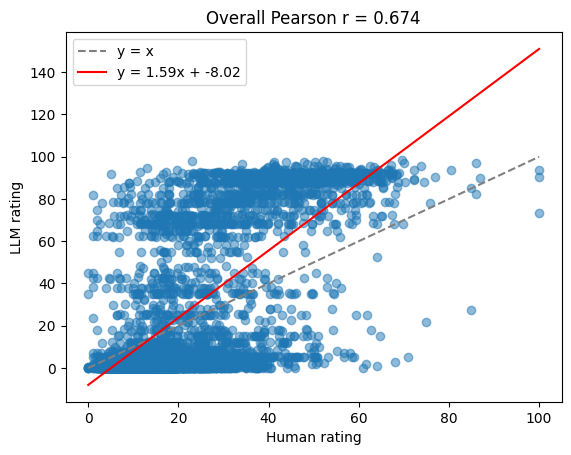

Disgust: r = 0.003


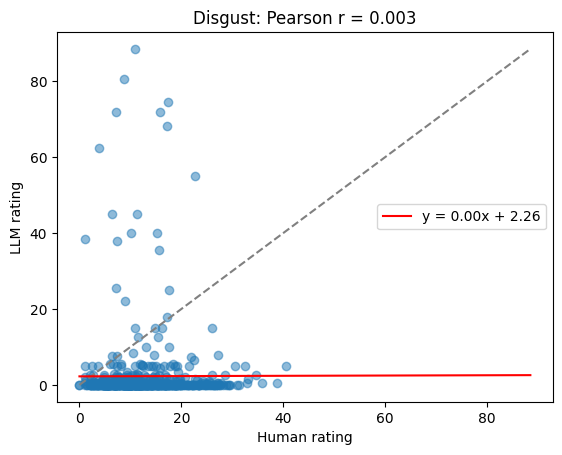

Liking: r = 0.286


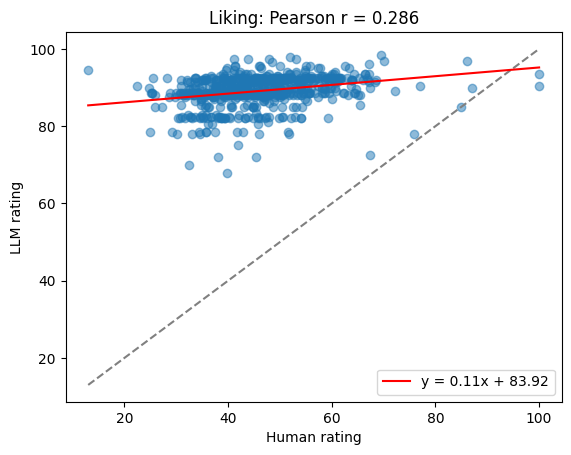

Surprise: r = 0.240


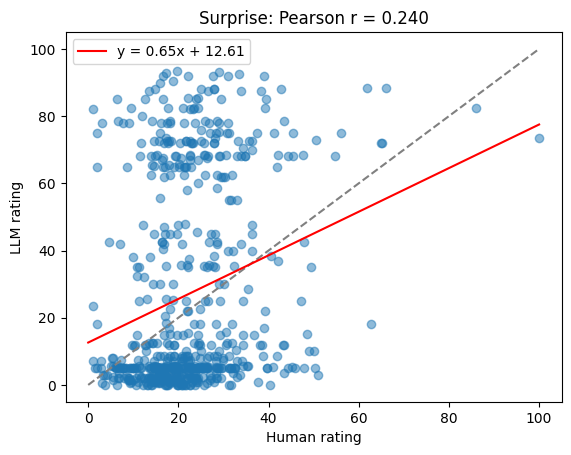

Anger: r = 0.270


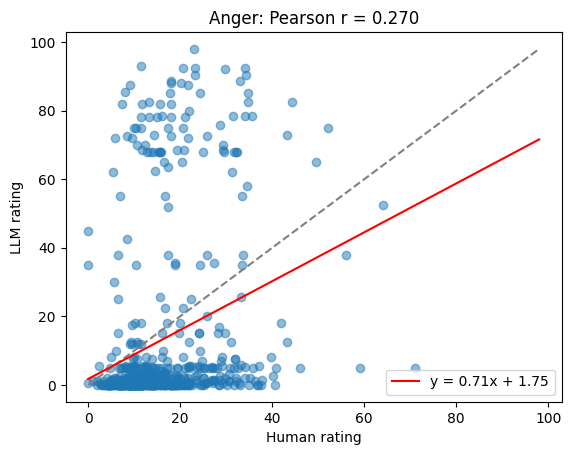

Fear: r = 0.175


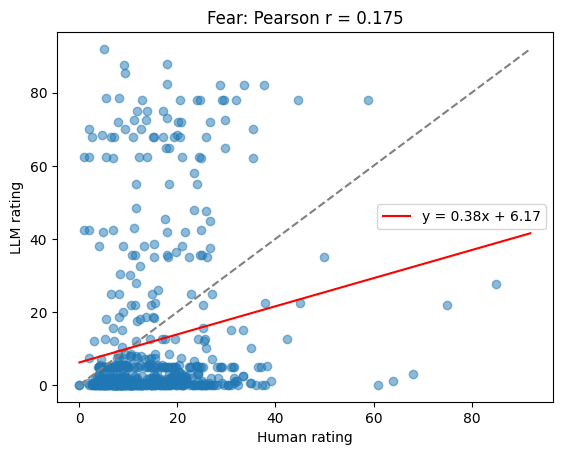

Joy: r = 0.383


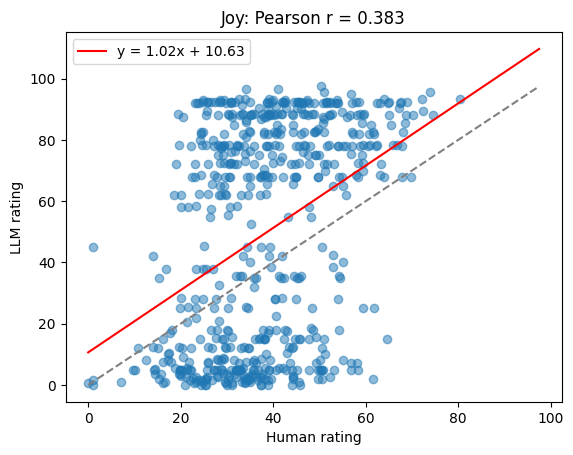

Sadness: r = 0.353


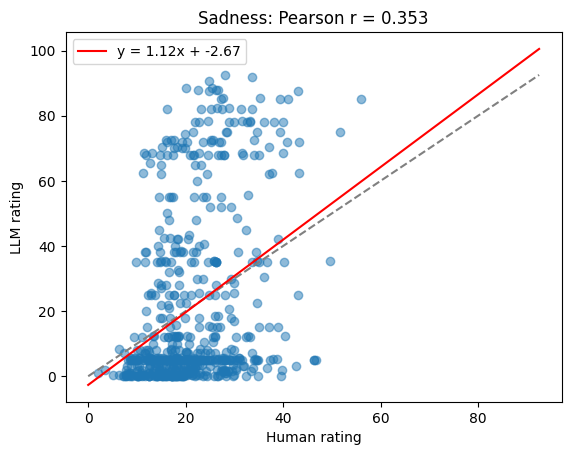

In [100]:
pearson_correlation_plot(merged_liking_rating)

In [131]:
for emo in merged_liking_rating['Emotion'].unique():
    print(f"\nEmotion: {emo}")
    
    # Get top 30 by human rating
    top_human_df = merged_liking_rating[merged_liking_rating['Emotion'] == emo].sort_values('emo_rating_human', ascending=False).head(30)
  

    # Get top 30 by LLM rating
    top_llm_df = merged_liking_rating[merged_liking_rating['Emotion'] == emo].sort_values('emo_rating_llm', ascending=False).head(30)


    # Compute overlap
    top_human_images = set(top_human_df['image'])
    top_llm_images = set(top_llm_df['image'])
    overlap = top_human_images.intersection(top_llm_images)
    jaccard = len(overlap) / len(top_human_images.union(top_llm_images))

    print(f"\nOverlap count: {len(overlap)}")
    print(f"Jaccard similarity: {jaccard:.3f}")
    
    print("\nOverlapping images with ratings:")
    for img in sorted(overlap):
        human_rating = top_human_df[top_human_df['image'] == img]['emo_rating_human'].values
        llm_rating = top_llm_df[top_llm_df['image'] == img]['emo_rating_llm'].values
        print(f"  {img}: Human = {human_rating[0]:.2f}, LLM = {llm_rating[0]:.2f}")
    
    print('-' * 60)



Emotion: Disgust

Overlap count: 1
Jaccard similarity: 0.017

Overlapping images with ratings:
  silvio-set-one-1963.jpg_colorField: Human = 27.25, LLM = 8.00
------------------------------------------------------------

Emotion: Liking

Overlap count: 4
Jaccard similarity: 0.071

Overlapping images with ratings:
  07Monet-nympheas.jpg_leslie: Human = 67.13, LLM = 96.00
  38Eyck-Virgin.jpg_leslie: Human = 70.00, LLM = 97.00
  69vanGogh_Starry_Night_Over_the_Rhone.jpg_leslie: Human = 86.00, LLM = 97.00
  the-japanese-bridge-the-water-lily-pond-1899.jpg_impressionism: Human = 69.53, LLM = 98.50
------------------------------------------------------------

Emotion: Surprise

Overlap count: 2
Jaccard similarity: 0.034

Overlapping images with ratings:
  composition-4.jpg_abstract: Human = 66.00, LLM = 88.50
  yellow-and-green-brushstrokes-1966.jpg_abstract: Human = 61.75, LLM = 88.50
------------------------------------------------------------

Emotion: Anger

Overlap count: 6
Jaccard sim

### ------------------------END-----------------------------

In [73]:
#mat_data = loadmat('../data/human-data/image_mean_rating.mat') I don't care about this for now

In [74]:
print(mat_data.keys())

NameError: name 'mat_data' is not defined

In [75]:
# Extract and squeeze data (MATLAB often returns extra dimensions)
image_names = mat_data['image_names'].squeeze()
image_categories = mat_data['image_categories'].squeeze()
mean_scores = mat_data['mean_score'].squeeze()

# Optional: decode strings if needed
if isinstance(image_names[0], np.ndarray):
    image_names = [name[0] for name in image_names]
if isinstance(image_categories[0], np.ndarray):
    image_categories = [cat[0] for cat in image_categories]

# Create DataFrame
rating_df = pd.DataFrame({
    'image_name': image_names,
    'image_category': image_categories,
    'mean_score': mean_scores
})


NameError: name 'mat_data' is not defined

In [76]:
#aesthetic rating from Kyo, one score per painting
rating_df

NameError: name 'rating_df' is not defined